In [1]:
import re
import os
import torch
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import T5TokenizerFast, T5ForConditionalGeneration
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from langdetect import detect

DOCS_DIR = 'data/documents_new'
PAGES_DIR = 'data/revision_new'

In [2]:
dataset_ids = list(map(lambda x: int(x.split('.')[0]), os.listdir(DOCS_DIR)))
dataset_ids[:5]

[3571, 3463, 1870, 266, 2773]

In [3]:
db_dict = {'obj_id': [], 'old_text': [], 'new_text': [], 'comment': [], 'docs': [], 'diff': []}
for dataset_obj_id in tqdm(dataset_ids):
    with open(f"{PAGES_DIR}/{dataset_obj_id}.json", 'r', encoding='utf-8') as f:
        page_json = json.load(f)
    docs_text = ''
    added_docs = set()
    count_docs = 0
    with open(f"{DOCS_DIR}/{dataset_obj_id}.txt", 'r', encoding='utf-8') as f:
        docs_text_plain = f.read()
        docs = docs_text_plain.split('\n\nDOC_DELIMITER_TOKEN\n\n')
        for doc_id, doc in enumerate(docs):
            if doc not in added_docs:
                added_docs.add(doc)
                count_docs += 1
                docs_text += f" DOC{count_docs}: {doc}"
            if count_docs > 2:
                break

    if count_docs < 3:
        continue
    if 'link' in db_dict['comment'] or 'ref' in db_dict['comment']:
        continue
    try:
        text_lang = detect(page_json['old_text'])
        comment_lang = detect(page_json['comment'])
    except:
        text_lang = ''
        comment_lang = ''

    if text_lang == 'en':
        diff = '\n'.join(page_json['change_texts'][0][0])
        db_dict['diff'].append(diff)
        db_dict['obj_id'].append(dataset_obj_id)
        db_dict['old_text'].append(page_json['old_text'])
        db_dict['new_text'].append(page_json['new_text'])
        db_dict['comment'].append('Comment: ' + page_json['comment'])
        db_dict['docs'].append(docs_text.strip())

  0%|          | 0/4171 [00:00<?, ?it/s]

In [4]:
df = pd.DataFrame.from_dict(db_dict)
print(df.shape)

(3749, 6)


In [5]:
df.head()

,obj_id,old_text,new_text,comment,docs,diff
0,3571,right\nCem Özdemir (born 21 December 1965 in B...,right|thumb|106px|Cem Özdemir\nCem Özdemir (bo...,Comment: +eo +photo,DOC1: Cem Özdemir (German: [ˌdʒɛm ˈʔœzdɛmiːɐ̯]...,|thumb|106px|Cem Özdemir
1,3463,Farrant is an English surname. It may refer to...,Farrant is an English surname. It may refer to...,"Comment: Adding link to orphaned article, Wiki...",DOC1: Tony Farrant Anthony John Farrant (20 Ju...,"Anthony Farrant (born 1955), New Zealand crick..."
2,1870,*Drakan - computer game\n*Glorianna - Quest fo...,*Drakan - computer game\n*Glorianna - Quest fo...,Comment: /* Computer and video games */ add link,"DOC1: Krynn - Dragonlance games and novels, Du...",Aurbis (\netheriu
3,266,WikiProjects connected with biology:\n*Ecology...,WikiProjects connected with biology:\n*Ecology...,Comment: added WikiProject Clinical medicine,DOC1: Antibiotics work by destabilizing the me...,Medicine\n*
4,2773,Key or central characters:\n*Raymond Babbitt (...,Key or central characters:\n*Raymond Babbitt (...,Comment: /* Film */ +1,DOC1: This is a list of fictional characters t...,", Adam Raki (played by Hugh Dancy) from the f..."


In [6]:
df = df.sample(8)

In [7]:
# df = df.iloc[7:8, :]

In [8]:
df.head()

,obj_id,old_text,new_text,comment,docs,diff
1560,1716,Stop Making Sense (1984) is a highly acclaimed...,Stop Making Sense (1984) is a highly acclaimed...,"Comment: Modified opening paragraph ""The title...",DOC1: I got a girlfriend thats better than tha...,"the lyrics of the song Girlfriend is Better: ""..."
1349,3310,The third hurricane of the season formed in th...,The third hurricane of the season formed in th...,Comment: /* Hurricane Three */ fmt,DOC1: Along the Gulf Coast of the United State...,(1926 USD) in
3091,2580,";Australia\n*Kilmore, Victoria\n;Northern Irel...",";Australia\n*Kilmore, Victoria\n;Northern Irel...",Comment: Info added,DOC1: Kilmore is in the Electoral Division of ...,"\n*Kilmore, County Antrim, a townland in Count..."
2957,2545,GameSpy called the game one of the weakest ear...,GameSpy called the game one of the weakest ear...,Comment: /* Reception and legacy */ cut,DOC1: Castlevania: The Adventure is an action-...,and cumbersome
3291,1384,"* Kamikaze (album), a 2004 album by Twista\n* ...","* Kamikaze (album), a 2004 album by Twista\n* ...",Comment: /* Music */ corr link,DOC1: Kamikaze by WALK THE MOONNew music a to...,"(of Nazareth)\n* ""Kamikaze"", a song by"


In [9]:
def get_tgt(row, text_to_lower=True, comment_to_lower=True, comment_delimiter=' TEXT '):
    new_text = row.new_text.lower() if text_to_lower else row.new_text
    coms = row.comment.lower() if comment_to_lower else row.comment
    tgt = coms + comment_delimiter + new_text
    return tgt

def get_src(row, text_to_lower=True, comment_to_lower=True, doc_delimiter=' DOCS '):
    old_text = row.old_text.lower() if text_to_lower else row.old_text 
    docs = row.docs.lower() if text_to_lower else row.docs 
    src = 'TEXT ' + old_text + doc_delimiter + docs
    return src
    
class EditDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: list, tokenizer, config,
                 text_to_lower=True, comment_to_lower=True):
        self.db = dataset
        self.tokenizer = tokenizer

        
        src_text = self.db.apply(lambda x: get_src(x, text_to_lower, comment_to_lower), axis=1).values
        tgt_text = self.db.apply(lambda x: get_tgt(x, text_to_lower, comment_to_lower), axis=1).values
        
        self.src_text_tokenized = [tokenizer(x,
                                       max_length=config.src_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in src_text]
        self.tgt_text_tokenized = [tokenizer(x,
                                       max_length=config.tgt_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in tgt_text]

    def __len__(self):
        return len(self.db)

    def __getitem__(self, idx: int):
        src = self.src_text_tokenized[idx]
        tgt = self.tgt_text_tokenized[idx]
        return src, tgt

    @staticmethod
    def collate_fn(samples, tokenizer, config):
        src_samples = [x[0] for x in samples]
        tgt_samples = [x[1] for x in samples]

        src_samples = tokenizer.pad(src_samples,
                                    padding='longest',
                                    max_length=config.final_src_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        tgt_samples = tokenizer.pad(tgt_samples,
                                    padding='longest',
                                    max_length=config.final_tgt_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        return (src_samples, tgt_samples), torch.ones(len(samples), 1)

In [10]:
from dataclasses import dataclass

@dataclass
class Config:
    pass
    
CONFIG = Config()
CONFIG.seed = 1337
CONFIG.src_max_len = 900
CONFIG.tgt_max_len = 900
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 8

tokenizer = T5TokenizerFast.from_pretrained(CONFIG.pretrained, model_max_length=1000)

In [11]:
ds_edit = EditDataset(df, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = EditDataset(df, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

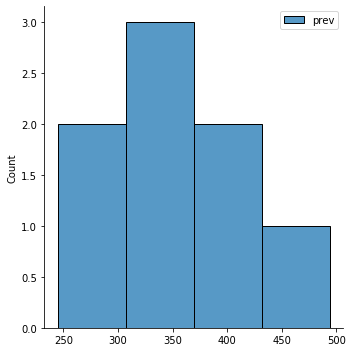

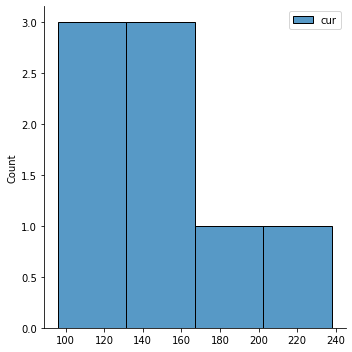

In [12]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_edit:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.displot(arr_src, label='prev');
plt.legend();
sns.displot(arr_tgt, label='cur');
plt.legend();

## Learning

In [13]:
CONFIG.batch_size = 8
CONFIG.final_src_max_len = 800
CONFIG.final_tgt_max_len = 500
loaders = {
    'train': torch.utils.data.DataLoader(ds_edit, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True)
}

In [14]:
class EditModel(nn.Module):
    def __init__(self, pretrained, config):
        super(EditModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, x):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [15]:
model = EditModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}_test_one_batch'
CONFIG.description = f'{CONFIG.name} p(comment, x_t+1 | x_t, doc)'
CONFIG.group = "wiki_edit_test"

In [16]:
!rm -rf ./models/"{CONFIG.description}"

In [17]:
import torch
import catalyst

from catalyst.core import IRunner
from catalyst.metrics._additive import AdditiveMetric
from catalyst.callbacks.metric import BatchMetricCallback, ICallbackBatchMetric


class ExactMatchMetric(ICallbackBatchMetric):
    def __init__(self, topk, compute_on_call=False):
        super().__init__(compute_on_call=compute_on_call, prefix='', suffix='')
        self.metric_name = 'exact_match'
        self.topk = topk
        self.metrics: List[AdditiveMetric] = [
            AdditiveMetric(compute_on_call=compute_on_call) for _ in range(len(self.topk))]

    def reset(self) -> None:
        for metric in self.metrics:
            metric.reset()

    def update(self, values, n_samples):
        for value, metric in zip(values, self.metrics):
            metric.update(value, n_samples)
        return values

    def update_key_value(self, values, n_samples):
        values = self.update(values, n_samples)
        output = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, values)
        }
        return output

    def compute(self):
        means, stds = zip(*(metric.compute() for metric in self.metrics))
        return means, stds

    def compute_key_value(self):
        means, stds = self.compute()
        output_mean = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, means)
        }
        output_std = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}/std": round(value, 6)
            for key, value in zip(self.topk, stds)
        }
        return {**output_mean, **output_std}


class ExactMatchCallback(BatchMetricCallback):

    def __init__(self, beam_size):
        super().__init__(
            metric= ExactMatchMetric((1,beam_size)) if beam_size > 1 else ExactMatchMetric((1,)),
            input_key='features', target_key='targets', log_on_batch=True)
        self.beam_size = beam_size

    def on_batch_end(self, runner: "IRunner") -> None:

        if runner.loader_key == 'train':
            runner.model.train()
        elif runner.loader_key.startswith('valid'):
            runner.model.eval()

            src = runner.batch['features'][0]
            tgt = runner.batch['features'][1]
            max_len = tgt.shape[1]
            with torch.no_grad():
                pred = runner.model.pretrained.generate(src.to(runner.engine.device),
                                                        attention_mask=(src != 0).float().to(runner.engine.device),
                                                        # pad_token_id=tokenizer.pad_token_id,
                                                        # bos_token_id=tokenizer.bos_token_id,
                                                        # eos_token_id=tokenizer.eos_token_id,
                                                        num_beams=self.beam_size,
                                                        num_return_sequences=self.beam_size,
                                                        max_length=max_len
                                                        )

            pred = pred[:,1:]
            pred = pred.view(-1, self.beam_size, pred.shape[1])
            acck = 0
            acc1 = 0
            for i in range(tgt.shape[0]):
                tgt_subseq = tgt[i, :pred.shape[2]].to(runner.engine.device)

                acck += float(torch.any(torch.all(tgt_subseq == pred[i], dim=1)))
                acc1 += float(torch.all(tgt_subseq == pred[i, 0]))

            acck /= len(src)
            acc1 /= len(src)

            metrics = self.metric.update_key_value([acc1, acck], len(src))

            runner.batch_metrics.update(metrics)

    def on_loader_end(self, runner: "IRunner") -> None:
        if runner.loader_key.startswith('valid'):
            metrics = self.metric.compute_key_value()
            metrics = runner.engine.mean_reduce_ddp_metrics(metrics)
            runner.loader_metrics.update(metrics)

In [18]:
CONFIG.n_epochs = 400
CONFIG.beam_size = 5

In [19]:
runner = dl.SupervisedRunner()

# CONFIG.scheduler = 'OneCycleLR(max_lr=0.005, base_momentum=0.85, max_momentum=0.95, div_factor=10.0)'

wandb_logger = dl.WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)
# wandb_logger.log_hparams(CONFIG.__dict__)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
#     scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.005, 
#                                                   total_steps=CONFIG.n_epochs*len(loaders_pattern['train']), 
#                                                   base_momentum=0.85, max_momentum=0.95, div_factor=10.0),
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        # dl.EarlyStoppingCallback(loader_key='valid', metric_key='exact_match02', minimize=False, patience=5),
        ExactMatchCallback(beam_size=CONFIG.beam_size),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jdev8 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


1/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (1/1000) loss: 8.28531265258789 | loss/mean: 8.28531265258789 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


1/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (1/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 6.224942207336426 | loss/mean: 6.224942207336426 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (1/1000) 


2/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (2/1000) loss: 6.469768524169922 | loss/mean: 6.469768524169922 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


2/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (2/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 4.607202529907227 | loss/mean: 4.607202529907227 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (2/1000) 


3/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (3/1000) loss: 4.9861063957214355 | loss/mean: 4.9861063957214355 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


3/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (3/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 3.4922125339508057 | loss/mean: 3.4922125339508057 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (3/1000) 


4/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (4/1000) loss: 4.111112117767334 | loss/mean: 4.111112117767334 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


4/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (4/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 2.7424187660217285 | loss/mean: 2.7424187660217285 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (4/1000) 


5/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (5/1000) loss: 2.8735995292663574 | loss/mean: 2.8735995292663574 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


5/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (5/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 2.16945481300354 | loss/mean: 2.16945481300354 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (5/1000) 


6/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (6/1000) loss: 2.4072465896606445 | loss/mean: 2.4072465896606445 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


6/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (6/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.7346779108047485 | loss/mean: 1.7346779108047485 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (6/1000) 


7/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (7/1000) loss: 2.266617774963379 | loss/mean: 2.266617774963379 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


7/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (7/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.452763319015503 | loss/mean: 1.452763319015503 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (7/1000) 


8/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (8/1000) loss: 1.9917361736297607 | loss/mean: 1.9917361736297607 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


8/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (8/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.3129818439483643 | loss/mean: 1.3129818439483643 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (8/1000) 


9/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (9/1000) loss: 1.958817958831787 | loss/mean: 1.958817958831787 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


9/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (9/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.2305694818496704 | loss/mean: 1.2305694818496704 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (9/1000) 


10/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (10/1000) loss: 1.5712536573410034 | loss/mean: 1.5712536573410034 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


10/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (10/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.1557742357254028 | loss/mean: 1.1557742357254028 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (10/1000) 


11/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (11/1000) loss: 1.5203139781951904 | loss/mean: 1.5203139781951904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


11/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (11/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.0932285785675049 | loss/mean: 1.0932285785675049 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (11/1000) 


12/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (12/1000) loss: 1.4700530767440796 | loss/mean: 1.4700530767440796 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


12/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (12/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 1.0381022691726685 | loss/mean: 1.0381022691726685 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (12/1000) 


13/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (13/1000) loss: 1.4752821922302246 | loss/mean: 1.4752821922302246 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


13/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (13/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.9919755458831787 | loss/mean: 0.9919755458831787 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (13/1000) 


14/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (14/1000) loss: 1.4310505390167236 | loss/mean: 1.4310505390167236 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


14/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (14/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.9521640539169312 | loss/mean: 0.9521640539169312 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (14/1000) 


15/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (15/1000) loss: 1.4027951955795288 | loss/mean: 1.4027951955795288 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


15/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (15/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.9166181683540344 | loss/mean: 0.9166181683540344 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (15/1000) 


16/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (16/1000) loss: 1.3976929187774658 | loss/mean: 1.3976929187774658 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


16/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (16/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.8850520253181458 | loss/mean: 0.8850520253181458 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (16/1000) 


17/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (17/1000) loss: 1.29600989818573 | loss/mean: 1.29600989818573 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


17/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (17/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.8577103018760681 | loss/mean: 0.8577103018760681 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (17/1000) 


18/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (18/1000) loss: 1.3099099397659302 | loss/mean: 1.3099099397659302 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


18/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (18/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.8330956101417542 | loss/mean: 0.8330956101417542 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (18/1000) 


19/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (19/1000) loss: 1.2802746295928955 | loss/mean: 1.2802746295928955 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


19/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (19/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.8113583922386169 | loss/mean: 0.8113583922386169 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (19/1000) 


20/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (20/1000) loss: 1.227872610092163 | loss/mean: 1.227872610092163 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


20/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (20/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.792174756526947 | loss/mean: 0.792174756526947 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (20/1000) 


21/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (21/1000) loss: 1.2031303644180298 | loss/mean: 1.2031303644180298 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


21/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (21/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.7745790481567383 | loss/mean: 0.7745790481567383 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (21/1000) 


22/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (22/1000) loss: 1.1509290933609009 | loss/mean: 1.1509290933609009 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


22/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (22/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.7588014006614685 | loss/mean: 0.7588014006614685 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (22/1000) 


23/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (23/1000) loss: 1.1372716426849365 | loss/mean: 1.1372716426849365 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


23/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (23/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.743904709815979 | loss/mean: 0.743904709815979 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (23/1000) 


24/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (24/1000) loss: 1.091799020767212 | loss/mean: 1.091799020767212 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


24/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (24/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.7297271490097046 | loss/mean: 0.7297271490097046 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (24/1000) 


25/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (25/1000) loss: 1.0709333419799805 | loss/mean: 1.0709333419799805 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


25/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (25/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.7159630656242371 | loss/mean: 0.7159630656242371 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (25/1000) 


26/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (26/1000) loss: 1.044729232788086 | loss/mean: 1.044729232788086 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


26/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (26/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.7029166221618652 | loss/mean: 0.7029166221618652 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (26/1000) 


27/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (27/1000) loss: 1.017310619354248 | loss/mean: 1.017310619354248 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


27/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (27/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6906929612159729 | loss/mean: 0.6906929612159729 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (27/1000) 


28/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (28/1000) loss: 1.0050249099731445 | loss/mean: 1.0050249099731445 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


28/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (28/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6789177656173706 | loss/mean: 0.6789177656173706 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (28/1000) 


29/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (29/1000) loss: 1.0131489038467407 | loss/mean: 1.0131489038467407 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


29/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (29/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.667549729347229 | loss/mean: 0.667549729347229 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (29/1000) 


30/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (30/1000) loss: 0.9236617088317871 | loss/mean: 0.9236617088317871 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


30/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (30/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6567782163619995 | loss/mean: 0.6567782163619995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (30/1000) 


31/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (31/1000) loss: 0.9590662717819214 | loss/mean: 0.9590662717819214 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


31/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (31/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6468386650085449 | loss/mean: 0.6468386650085449 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (31/1000) 


32/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (32/1000) loss: 0.9121398329734802 | loss/mean: 0.9121398329734802 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


32/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (32/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6375314593315125 | loss/mean: 0.6375314593315125 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (32/1000) 


33/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (33/1000) loss: 0.8695862293243408 | loss/mean: 0.8695862293243408 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


33/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (33/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6285589933395386 | loss/mean: 0.6285589933395386 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (33/1000) 


34/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (34/1000) loss: 0.8896523118019104 | loss/mean: 0.8896523118019104 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


34/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (34/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.62003093957901 | loss/mean: 0.62003093957901 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (34/1000) 


35/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (35/1000) loss: 0.8968968987464905 | loss/mean: 0.8968968987464905 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


35/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (35/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6117911338806152 | loss/mean: 0.6117911338806152 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (35/1000) 


36/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (36/1000) loss: 0.8948680758476257 | loss/mean: 0.8948680758476257 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


36/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (36/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.6038899421691895 | loss/mean: 0.6038899421691895 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (36/1000) 


37/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (37/1000) loss: 0.8804287314414978 | loss/mean: 0.8804287314414978 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


37/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (37/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5961246490478516 | loss/mean: 0.5961246490478516 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (37/1000) 


38/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (38/1000) loss: 0.8074321746826172 | loss/mean: 0.8074321746826172 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


38/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (38/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5887071490287781 | loss/mean: 0.5887071490287781 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (38/1000) 


39/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (39/1000) loss: 0.820487380027771 | loss/mean: 0.820487380027771 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


39/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (39/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5818099975585938 | loss/mean: 0.5818099975585938 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (39/1000) 


40/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (40/1000) loss: 0.8285207152366638 | loss/mean: 0.8285207152366638 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


40/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (40/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5750587582588196 | loss/mean: 0.5750587582588196 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (40/1000) 


41/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (41/1000) loss: 0.7892069220542908 | loss/mean: 0.7892069220542908 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


41/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (41/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5683370232582092 | loss/mean: 0.5683370232582092 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (41/1000) 


42/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (42/1000) loss: 0.760744571685791 | loss/mean: 0.760744571685791 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


42/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (42/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5619480609893799 | loss/mean: 0.5619480609893799 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (42/1000) 


43/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (43/1000) loss: 0.773888349533081 | loss/mean: 0.773888349533081 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


43/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (43/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5556532740592957 | loss/mean: 0.5556532740592957 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (43/1000) 


44/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (44/1000) loss: 0.755770742893219 | loss/mean: 0.755770742893219 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


44/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (44/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5495200753211975 | loss/mean: 0.5495200753211975 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (44/1000) 


45/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (45/1000) loss: 0.7542784214019775 | loss/mean: 0.7542784214019775 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


45/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (45/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5432279109954834 | loss/mean: 0.5432279109954834 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (45/1000) 


46/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (46/1000) loss: 0.7307957410812378 | loss/mean: 0.7307957410812378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


46/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (46/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5368390083312988 | loss/mean: 0.5368390083312988 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (46/1000) 


47/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (47/1000) loss: 0.6825675368309021 | loss/mean: 0.6825675368309021 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


47/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (47/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5306707620620728 | loss/mean: 0.5306707620620728 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (47/1000) 


48/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (48/1000) loss: 0.7241122722625732 | loss/mean: 0.7241122722625732 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


48/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (48/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5244306921958923 | loss/mean: 0.5244306921958923 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (48/1000) 


49/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (49/1000) loss: 0.7318741083145142 | loss/mean: 0.7318741083145142 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


49/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (49/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5182908177375793 | loss/mean: 0.5182908177375793 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (49/1000) 


50/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (50/1000) loss: 0.673896074295044 | loss/mean: 0.673896074295044 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


50/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (50/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5123633146286011 | loss/mean: 0.5123633146286011 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (50/1000) 


51/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (51/1000) loss: 0.7229616045951843 | loss/mean: 0.7229616045951843 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


51/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (51/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5063303709030151 | loss/mean: 0.5063303709030151 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (51/1000) 


52/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (52/1000) loss: 0.6793668270111084 | loss/mean: 0.6793668270111084 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


52/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (52/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.5003154873847961 | loss/mean: 0.5003154873847961 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (52/1000) 


53/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (53/1000) loss: 0.6894931197166443 | loss/mean: 0.6894931197166443 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


53/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (53/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.49467581510543823 | loss/mean: 0.49467581510543823 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (53/1000) 


54/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (54/1000) loss: 0.6483532786369324 | loss/mean: 0.6483532786369324 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


54/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (54/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4893207848072052 | loss/mean: 0.4893207848072052 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (54/1000) 


55/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (55/1000) loss: 0.6696169972419739 | loss/mean: 0.6696169972419739 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


55/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (55/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.48403874039649963 | loss/mean: 0.48403874039649963 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (55/1000) 


56/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (56/1000) loss: 0.6649205088615417 | loss/mean: 0.6649205088615417 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


56/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (56/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4788489043712616 | loss/mean: 0.4788489043712616 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (56/1000) 


57/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (57/1000) loss: 0.6010651588439941 | loss/mean: 0.6010651588439941 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


57/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (57/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.47349366545677185 | loss/mean: 0.47349366545677185 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (57/1000) 


58/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (58/1000) loss: 0.6006086468696594 | loss/mean: 0.6006086468696594 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


58/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (58/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.46818462014198303 | loss/mean: 0.46818462014198303 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (58/1000) 


59/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (59/1000) loss: 0.6223498582839966 | loss/mean: 0.6223498582839966 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


59/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (59/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.463168203830719 | loss/mean: 0.463168203830719 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (59/1000) 


60/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (60/1000) loss: 0.6415399312973022 | loss/mean: 0.6415399312973022 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


60/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (60/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4585537314414978 | loss/mean: 0.4585537314414978 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (60/1000) 


61/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (61/1000) loss: 0.6281266808509827 | loss/mean: 0.6281266808509827 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


61/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (61/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.45408472418785095 | loss/mean: 0.45408472418785095 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (61/1000) 


62/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (62/1000) loss: 0.6230480074882507 | loss/mean: 0.6230480074882507 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


62/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (62/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.44984447956085205 | loss/mean: 0.44984447956085205 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (62/1000) 


63/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (63/1000) loss: 0.6004681587219238 | loss/mean: 0.6004681587219238 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


63/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (63/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.445585697889328 | loss/mean: 0.445585697889328 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (63/1000) 


64/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (64/1000) loss: 0.580269992351532 | loss/mean: 0.580269992351532 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


64/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (64/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.44150617718696594 | loss/mean: 0.44150617718696594 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (64/1000) 


65/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (65/1000) loss: 0.563850998878479 | loss/mean: 0.563850998878479 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


65/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (65/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4374551475048065 | loss/mean: 0.4374551475048065 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (65/1000) 


66/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (66/1000) loss: 0.5671843886375427 | loss/mean: 0.5671843886375427 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


66/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (66/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4332161247730255 | loss/mean: 0.4332161247730255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (66/1000) 


67/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (67/1000) loss: 0.5742108821868896 | loss/mean: 0.5742108821868896 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


67/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (67/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4289490580558777 | loss/mean: 0.4289490580558777 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (67/1000) 


68/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (68/1000) loss: 0.5715838670730591 | loss/mean: 0.5715838670730591 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


68/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (68/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4247274100780487 | loss/mean: 0.4247274100780487 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (68/1000) 


69/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (69/1000) loss: 0.547015905380249 | loss/mean: 0.547015905380249 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


69/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (69/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.4203530251979828 | loss/mean: 0.4203530251979828 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (69/1000) 


70/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (70/1000) loss: 0.5641673803329468 | loss/mean: 0.5641673803329468 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


70/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (70/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.41580823063850403 | loss/mean: 0.41580823063850403 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (70/1000) 


71/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (71/1000) loss: 0.5487486720085144 | loss/mean: 0.5487486720085144 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


71/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (71/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.41136863827705383 | loss/mean: 0.41136863827705383 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (71/1000) 


72/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (72/1000) loss: 0.539019763469696 | loss/mean: 0.539019763469696 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


72/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (72/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.406840980052948 | loss/mean: 0.406840980052948 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (72/1000) 


73/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (73/1000) loss: 0.5620660185813904 | loss/mean: 0.5620660185813904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


73/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (73/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.40247809886932373 | loss/mean: 0.40247809886932373 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (73/1000) 


74/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (74/1000) loss: 0.5420947074890137 | loss/mean: 0.5420947074890137 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


74/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (74/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3983323574066162 | loss/mean: 0.3983323574066162 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (74/1000) 


75/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (75/1000) loss: 0.5357585549354553 | loss/mean: 0.5357585549354553 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


75/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (75/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3943346440792084 | loss/mean: 0.3943346440792084 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (75/1000) 


76/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (76/1000) loss: 0.519115686416626 | loss/mean: 0.519115686416626 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


76/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (76/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.39045250415802 | loss/mean: 0.39045250415802 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (76/1000) 


77/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (77/1000) loss: 0.5120136737823486 | loss/mean: 0.5120136737823486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


77/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (77/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3866327404975891 | loss/mean: 0.3866327404975891 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (77/1000) 


78/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (78/1000) loss: 0.514691948890686 | loss/mean: 0.514691948890686 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


78/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (78/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.38280442357063293 | loss/mean: 0.38280442357063293 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (78/1000) 


79/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (79/1000) loss: 0.5125852823257446 | loss/mean: 0.5125852823257446 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


79/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (79/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.378903865814209 | loss/mean: 0.378903865814209 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (79/1000) 


80/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (80/1000) loss: 0.5014703869819641 | loss/mean: 0.5014703869819641 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


80/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (80/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3753655254840851 | loss/mean: 0.3753655254840851 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (80/1000) 


81/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (81/1000) loss: 0.5325881838798523 | loss/mean: 0.5325881838798523 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


81/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (81/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3721696138381958 | loss/mean: 0.3721696138381958 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (81/1000) 


82/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (82/1000) loss: 0.5026180744171143 | loss/mean: 0.5026180744171143 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


82/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (82/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3686921000480652 | loss/mean: 0.3686921000480652 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (82/1000) 


83/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (83/1000) loss: 0.5109767913818359 | loss/mean: 0.5109767913818359 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


83/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (83/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3652714192867279 | loss/mean: 0.3652714192867279 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (83/1000) 


84/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (84/1000) loss: 0.502296507358551 | loss/mean: 0.502296507358551 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


84/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (84/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3617345690727234 | loss/mean: 0.3617345690727234 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (84/1000) 


85/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (85/1000) loss: 0.46044081449508667 | loss/mean: 0.46044081449508667 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


85/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (85/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3584352433681488 | loss/mean: 0.3584352433681488 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (85/1000) 


86/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (86/1000) loss: 0.5101189017295837 | loss/mean: 0.5101189017295837 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


86/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (86/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.35518643260002136 | loss/mean: 0.35518643260002136 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (86/1000) 


87/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (87/1000) loss: 0.4907620847225189 | loss/mean: 0.4907620847225189 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


87/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (87/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3513234555721283 | loss/mean: 0.3513234555721283 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (87/1000) 


88/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (88/1000) loss: 0.4864392876625061 | loss/mean: 0.4864392876625061 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


88/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (88/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3480047881603241 | loss/mean: 0.3480047881603241 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (88/1000) 


89/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (89/1000) loss: 0.5009534955024719 | loss/mean: 0.5009534955024719 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


89/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (89/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3446160852909088 | loss/mean: 0.3446160852909088 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (89/1000) 


90/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (90/1000) loss: 0.4843084216117859 | loss/mean: 0.4843084216117859 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


90/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (90/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3414047956466675 | loss/mean: 0.3414047956466675 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (90/1000) 


91/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (91/1000) loss: 0.4973636865615845 | loss/mean: 0.4973636865615845 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


91/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (91/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.33803507685661316 | loss/mean: 0.33803507685661316 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (91/1000) 


92/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (92/1000) loss: 0.45099303126335144 | loss/mean: 0.45099303126335144 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


92/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (92/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.33454430103302 | loss/mean: 0.33454430103302 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (92/1000) 


93/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (93/1000) loss: 0.4431098401546478 | loss/mean: 0.4431098401546478 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


93/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (93/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.33110859990119934 | loss/mean: 0.33110859990119934 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (93/1000) 


94/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (94/1000) loss: 0.46622559428215027 | loss/mean: 0.46622559428215027 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


94/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (94/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3278437554836273 | loss/mean: 0.3278437554836273 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (94/1000) 


95/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (95/1000) loss: 0.4027175307273865 | loss/mean: 0.4027175307273865 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


95/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (95/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.32461491227149963 | loss/mean: 0.32461491227149963 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (95/1000) 


96/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (96/1000) loss: 0.44765275716781616 | loss/mean: 0.44765275716781616 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


96/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (96/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3212287425994873 | loss/mean: 0.3212287425994873 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (96/1000) 


97/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (97/1000) loss: 0.44834914803504944 | loss/mean: 0.44834914803504944 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


97/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (97/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.31776735186576843 | loss/mean: 0.31776735186576843 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (97/1000) 


98/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (98/1000) loss: 0.43522799015045166 | loss/mean: 0.43522799015045166 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


98/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (98/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3146274983882904 | loss/mean: 0.3146274983882904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (98/1000) 


99/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (99/1000) loss: 0.4356578290462494 | loss/mean: 0.4356578290462494 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


99/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (99/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3110528886318207 | loss/mean: 0.3110528886318207 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (99/1000) 


100/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (100/1000) loss: 0.4308239221572876 | loss/mean: 0.4308239221572876 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


100/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (100/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3073316216468811 | loss/mean: 0.3073316216468811 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (100/1000) 


101/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (101/1000) loss: 0.41523733735084534 | loss/mean: 0.41523733735084534 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


101/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (101/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3038647174835205 | loss/mean: 0.3038647174835205 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (101/1000) 


102/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (102/1000) loss: 0.43667134642601013 | loss/mean: 0.43667134642601013 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


102/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (102/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.3003920614719391 | loss/mean: 0.3003920614719391 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (102/1000) 


103/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (103/1000) loss: 0.4119279980659485 | loss/mean: 0.4119279980659485 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


103/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (103/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2968420386314392 | loss/mean: 0.2968420386314392 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (103/1000) 


104/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (104/1000) loss: 0.4063122570514679 | loss/mean: 0.4063122570514679 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


104/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (104/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.293607234954834 | loss/mean: 0.293607234954834 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (104/1000) 


105/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (105/1000) loss: 0.4478762149810791 | loss/mean: 0.4478762149810791 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


105/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (105/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.29048383235931396 | loss/mean: 0.29048383235931396 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (105/1000) 


106/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (106/1000) loss: 0.42036086320877075 | loss/mean: 0.42036086320877075 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


106/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (106/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.28730374574661255 | loss/mean: 0.28730374574661255 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (106/1000) 


107/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (107/1000) loss: 0.41437163949012756 | loss/mean: 0.41437163949012756 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


107/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (107/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2842228412628174 | loss/mean: 0.2842228412628174 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (107/1000) 


108/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (108/1000) loss: 0.4013668894767761 | loss/mean: 0.4013668894767761 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


108/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (108/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2811294496059418 | loss/mean: 0.2811294496059418 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (108/1000) 


109/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (109/1000) loss: 0.4027552604675293 | loss/mean: 0.4027552604675293 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


109/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (109/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2779693901538849 | loss/mean: 0.2779693901538849 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (109/1000) 


110/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (110/1000) loss: 0.40586480498313904 | loss/mean: 0.40586480498313904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


110/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (110/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2747780382633209 | loss/mean: 0.2747780382633209 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (110/1000) 


111/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (111/1000) loss: 0.4048711657524109 | loss/mean: 0.4048711657524109 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


111/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (111/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.27139195799827576 | loss/mean: 0.27139195799827576 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (111/1000) 


112/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (112/1000) loss: 0.37872937321662903 | loss/mean: 0.37872937321662903 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


112/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (112/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2682032287120819 | loss/mean: 0.2682032287120819 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (112/1000) 


113/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (113/1000) loss: 0.41027286648750305 | loss/mean: 0.41027286648750305 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


113/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (113/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2651595175266266 | loss/mean: 0.2651595175266266 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (113/1000) 


114/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (114/1000) loss: 0.4179224669933319 | loss/mean: 0.4179224669933319 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


114/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (114/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.26186010241508484 | loss/mean: 0.26186010241508484 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (114/1000) 


115/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (115/1000) loss: 0.38670361042022705 | loss/mean: 0.38670361042022705 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


115/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (115/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2589792311191559 | loss/mean: 0.2589792311191559 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (115/1000) 


116/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (116/1000) loss: 0.38576897978782654 | loss/mean: 0.38576897978782654 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


116/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (116/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.25615593791007996 | loss/mean: 0.25615593791007996 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (116/1000) 


117/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (117/1000) loss: 0.3783875107765198 | loss/mean: 0.3783875107765198 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


117/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (117/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.25343868136405945 | loss/mean: 0.25343868136405945 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (117/1000) 


118/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (118/1000) loss: 0.36606481671333313 | loss/mean: 0.36606481671333313 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


118/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (118/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2506846487522125 | loss/mean: 0.2506846487522125 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (118/1000) 


119/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (119/1000) loss: 0.3693738281726837 | loss/mean: 0.3693738281726837 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


119/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (119/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.24795833230018616 | loss/mean: 0.24795833230018616 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (119/1000) 


120/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (120/1000) loss: 0.3888515830039978 | loss/mean: 0.3888515830039978 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


120/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (120/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2451705038547516 | loss/mean: 0.2451705038547516 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (120/1000) 


121/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (121/1000) loss: 0.37370434403419495 | loss/mean: 0.37370434403419495 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


121/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (121/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.24249699711799622 | loss/mean: 0.24249699711799622 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (121/1000) 


122/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (122/1000) loss: 0.3912941515445709 | loss/mean: 0.3912941515445709 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


122/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (122/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.23973293602466583 | loss/mean: 0.23973293602466583 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (122/1000) 


123/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (123/1000) loss: 0.3830353915691376 | loss/mean: 0.3830353915691376 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


123/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (123/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.23708710074424744 | loss/mean: 0.23708710074424744 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (123/1000) 


124/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (124/1000) loss: 0.34378013014793396 | loss/mean: 0.34378013014793396 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


124/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (124/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.23432622849941254 | loss/mean: 0.23432622849941254 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (124/1000) 


125/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (125/1000) loss: 0.35304680466651917 | loss/mean: 0.35304680466651917 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


125/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (125/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2313920557498932 | loss/mean: 0.2313920557498932 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (125/1000) 


126/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (126/1000) loss: 0.33828210830688477 | loss/mean: 0.33828210830688477 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


126/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (126/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.22849471867084503 | loss/mean: 0.22849471867084503 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (126/1000) 


127/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (127/1000) loss: 0.3367047607898712 | loss/mean: 0.3367047607898712 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


127/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (127/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.22557835280895233 | loss/mean: 0.22557835280895233 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (127/1000) 


128/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (128/1000) loss: 0.3351491391658783 | loss/mean: 0.3351491391658783 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


128/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (128/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.22274638712406158 | loss/mean: 0.22274638712406158 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (128/1000) 


129/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (129/1000) loss: 0.3603445887565613 | loss/mean: 0.3603445887565613 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


129/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (129/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.22002117335796356 | loss/mean: 0.22002117335796356 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (129/1000) 


130/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (130/1000) loss: 0.3430871367454529 | loss/mean: 0.3430871367454529 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


130/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (130/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.21730530261993408 | loss/mean: 0.21730530261993408 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (130/1000) 


131/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (131/1000) loss: 0.34159624576568604 | loss/mean: 0.34159624576568604 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


131/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (131/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.21455435454845428 | loss/mean: 0.21455435454845428 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (131/1000) 


132/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (132/1000) loss: 0.317364901304245 | loss/mean: 0.317364901304245 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


132/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (132/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.2119230479001999 | loss/mean: 0.2119230479001999 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (132/1000) 


133/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (133/1000) loss: 0.3287523686885834 | loss/mean: 0.3287523686885834 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


133/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (133/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.20928432047367096 | loss/mean: 0.20928432047367096 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (133/1000) 


134/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (134/1000) loss: 0.35278019309043884 | loss/mean: 0.35278019309043884 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


134/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (134/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.20663024485111237 | loss/mean: 0.20663024485111237 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (134/1000) 


135/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (135/1000) loss: 0.34347519278526306 | loss/mean: 0.34347519278526306 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


135/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (135/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.20402520895004272 | loss/mean: 0.20402520895004272 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (135/1000) 


136/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (136/1000) loss: 0.32046955823898315 | loss/mean: 0.32046955823898315 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


136/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (136/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.201504647731781 | loss/mean: 0.201504647731781 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (136/1000) 


137/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (137/1000) loss: 0.32905060052871704 | loss/mean: 0.32905060052871704 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


137/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (137/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.19907091557979584 | loss/mean: 0.19907091557979584 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (137/1000) 


138/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (138/1000) loss: 0.33371445536613464 | loss/mean: 0.33371445536613464 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


138/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (138/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.19654259085655212 | loss/mean: 0.19654259085655212 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (138/1000) 


139/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (139/1000) loss: 0.31093689799308777 | loss/mean: 0.31093689799308777 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


139/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (139/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.19413898885250092 | loss/mean: 0.19413898885250092 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (139/1000) 


140/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (140/1000) loss: 0.316549152135849 | loss/mean: 0.316549152135849 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


140/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (140/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.19173763692378998 | loss/mean: 0.19173763692378998 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (140/1000) 


141/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (141/1000) loss: 0.3106978237628937 | loss/mean: 0.3106978237628937 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


141/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (141/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.18935774266719818 | loss/mean: 0.18935774266719818 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (141/1000) 


142/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (142/1000) loss: 0.2938740849494934 | loss/mean: 0.2938740849494934 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


142/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (142/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.18689939379692078 | loss/mean: 0.18689939379692078 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (142/1000) 


143/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (143/1000) loss: 0.2907960116863251 | loss/mean: 0.2907960116863251 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


143/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (143/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.18434536457061768 | loss/mean: 0.18434536457061768 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (143/1000) 


144/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (144/1000) loss: 0.29118800163269043 | loss/mean: 0.29118800163269043 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


144/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (144/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1818740963935852 | loss/mean: 0.1818740963935852 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (144/1000) 


145/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (145/1000) loss: 0.29308557510375977 | loss/mean: 0.29308557510375977 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


145/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (145/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.17940199375152588 | loss/mean: 0.17940199375152588 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (145/1000) 


146/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (146/1000) loss: 0.2983652353286743 | loss/mean: 0.2983652353286743 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


146/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (146/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1768171638250351 | loss/mean: 0.1768171638250351 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (146/1000) 


147/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (147/1000) loss: 0.29379820823669434 | loss/mean: 0.29379820823669434 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


147/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (147/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1742519587278366 | loss/mean: 0.1742519587278366 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (147/1000) 


148/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (148/1000) loss: 0.2802833020687103 | loss/mean: 0.2802833020687103 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


148/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (148/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.17173348367214203 | loss/mean: 0.17173348367214203 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (148/1000) 


149/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (149/1000) loss: 0.27971190214157104 | loss/mean: 0.27971190214157104 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


149/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (149/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1692737489938736 | loss/mean: 0.1692737489938736 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (149/1000) 


150/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (150/1000) loss: 0.28473350405693054 | loss/mean: 0.28473350405693054 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


150/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (150/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.166743665933609 | loss/mean: 0.166743665933609 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (150/1000) 


151/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (151/1000) loss: 0.2831481397151947 | loss/mean: 0.2831481397151947 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


151/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (151/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.16417501866817474 | loss/mean: 0.16417501866817474 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (151/1000) 


152/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (152/1000) loss: 0.27644023299217224 | loss/mean: 0.27644023299217224 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


152/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (152/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.16169500350952148 | loss/mean: 0.16169500350952148 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (152/1000) 


153/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (153/1000) loss: 0.27184662222862244 | loss/mean: 0.27184662222862244 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


153/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (153/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.15928864479064941 | loss/mean: 0.15928864479064941 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (153/1000) 


154/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (154/1000) loss: 0.2675839066505432 | loss/mean: 0.2675839066505432 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


154/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (154/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.15688280761241913 | loss/mean: 0.15688280761241913 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (154/1000) 


155/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (155/1000) loss: 0.27546435594558716 | loss/mean: 0.27546435594558716 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


155/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (155/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.15452870726585388 | loss/mean: 0.15452870726585388 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (155/1000) 


156/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (156/1000) loss: 0.28006303310394287 | loss/mean: 0.28006303310394287 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


156/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (156/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.15218371152877808 | loss/mean: 0.15218371152877808 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (156/1000) 


157/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (157/1000) loss: 0.2548291087150574 | loss/mean: 0.2548291087150574 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


157/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (157/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.14992927014827728 | loss/mean: 0.14992927014827728 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (157/1000) 


158/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (158/1000) loss: 0.2634371817111969 | loss/mean: 0.2634371817111969 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


158/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (158/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.14774297177791595 | loss/mean: 0.14774297177791595 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (158/1000) 


159/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (159/1000) loss: 0.2703770697116852 | loss/mean: 0.2703770697116852 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


159/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (159/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.14559805393218994 | loss/mean: 0.14559805393218994 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (159/1000) 


160/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (160/1000) loss: 0.2689288556575775 | loss/mean: 0.2689288556575775 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


160/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (160/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.14349409937858582 | loss/mean: 0.14349409937858582 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (160/1000) 


161/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (161/1000) loss: 0.25443944334983826 | loss/mean: 0.25443944334983826 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


161/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (161/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.14143326878547668 | loss/mean: 0.14143326878547668 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (161/1000) 


162/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (162/1000) loss: 0.25803959369659424 | loss/mean: 0.25803959369659424 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


162/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (162/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1393846571445465 | loss/mean: 0.1393846571445465 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (162/1000) 


163/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (163/1000) loss: 0.23459841310977936 | loss/mean: 0.23459841310977936 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


163/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (163/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.13729342818260193 | loss/mean: 0.13729342818260193 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (163/1000) 


164/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (164/1000) loss: 0.25109297037124634 | loss/mean: 0.25109297037124634 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


164/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (164/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.13527576625347137 | loss/mean: 0.13527576625347137 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (164/1000) 


165/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (165/1000) loss: 0.24367401003837585 | loss/mean: 0.24367401003837585 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


165/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (165/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.13324709236621857 | loss/mean: 0.13324709236621857 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (165/1000) 


166/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (166/1000) loss: 0.25268426537513733 | loss/mean: 0.25268426537513733 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


166/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (166/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.13124339282512665 | loss/mean: 0.13124339282512665 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (166/1000) 


167/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (167/1000) loss: 0.23530705273151398 | loss/mean: 0.23530705273151398 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


167/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (167/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.12918034195899963 | loss/mean: 0.12918034195899963 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (167/1000) 


168/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (168/1000) loss: 0.22892940044403076 | loss/mean: 0.22892940044403076 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


168/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (168/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.12710215151309967 | loss/mean: 0.12710215151309967 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (168/1000) 


169/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (169/1000) loss: 0.23203299939632416 | loss/mean: 0.23203299939632416 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


169/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (169/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1249566525220871 | loss/mean: 0.1249566525220871 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (169/1000) 


170/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (170/1000) loss: 0.23829367756843567 | loss/mean: 0.23829367756843567 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


170/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (170/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1228739395737648 | loss/mean: 0.1228739395737648 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (170/1000) 


171/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (171/1000) loss: 0.24045413732528687 | loss/mean: 0.24045413732528687 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


171/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (171/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.12080992013216019 | loss/mean: 0.12080992013216019 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (171/1000) 


172/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (172/1000) loss: 0.2258024960756302 | loss/mean: 0.2258024960756302 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


172/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (172/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.11871849745512009 | loss/mean: 0.11871849745512009 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (172/1000) 


173/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (173/1000) loss: 0.22030219435691833 | loss/mean: 0.22030219435691833 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


173/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (173/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.11665940284729004 | loss/mean: 0.11665940284729004 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (173/1000) 


174/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (174/1000) loss: 0.20921893417835236 | loss/mean: 0.20921893417835236 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


174/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (174/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.1146327331662178 | loss/mean: 0.1146327331662178 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (174/1000) 


175/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (175/1000) loss: 0.22306498885154724 | loss/mean: 0.22306498885154724 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


175/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (175/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.11249532550573349 | loss/mean: 0.11249532550573349 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (175/1000) 


176/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (176/1000) loss: 0.22100740671157837 | loss/mean: 0.22100740671157837 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


176/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (176/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.11040890961885452 | loss/mean: 0.11040890961885452 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (176/1000) 


177/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (177/1000) loss: 0.22487740218639374 | loss/mean: 0.22487740218639374 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


177/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (177/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.10840611159801483 | loss/mean: 0.10840611159801483 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (177/1000) 


178/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (178/1000) loss: 0.2132290154695511 | loss/mean: 0.2132290154695511 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


178/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (178/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.10642851144075394 | loss/mean: 0.10642851144075394 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (178/1000) 


179/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (179/1000) loss: 0.20834019780158997 | loss/mean: 0.20834019780158997 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


179/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (179/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.10447536408901215 | loss/mean: 0.10447536408901215 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (179/1000) 


180/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (180/1000) loss: 0.21770493686199188 | loss/mean: 0.21770493686199188 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


180/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (180/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.10250239074230194 | loss/mean: 0.10250239074230194 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (180/1000) 


181/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (181/1000) loss: 0.21500514447689056 | loss/mean: 0.21500514447689056 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


181/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (181/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.10037705302238464 | loss/mean: 0.10037705302238464 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (181/1000) 


182/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (182/1000) loss: 0.19930467009544373 | loss/mean: 0.19930467009544373 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


182/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (182/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0984148234128952 | loss/mean: 0.0984148234128952 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (182/1000) 


183/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (183/1000) loss: 0.21910929679870605 | loss/mean: 0.21910929679870605 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


183/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (183/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.09654521197080612 | loss/mean: 0.09654521197080612 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (183/1000) 


184/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (184/1000) loss: 0.2051810324192047 | loss/mean: 0.2051810324192047 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


184/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (184/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.09467118978500366 | loss/mean: 0.09467118978500366 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (184/1000) 


185/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (185/1000) loss: 0.20875222980976105 | loss/mean: 0.20875222980976105 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


185/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (185/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.09283386915922165 | loss/mean: 0.09283386915922165 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (185/1000) 


186/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (186/1000) loss: 0.20056267082691193 | loss/mean: 0.20056267082691193 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


186/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (186/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.09100546687841415 | loss/mean: 0.09100546687841415 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (186/1000) 


187/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (187/1000) loss: 0.20130079984664917 | loss/mean: 0.20130079984664917 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


187/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (187/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.08923294395208359 | loss/mean: 0.08923294395208359 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (187/1000) 


188/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (188/1000) loss: 0.17958326637744904 | loss/mean: 0.17958326637744904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


188/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (188/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.08752211183309555 | loss/mean: 0.08752211183309555 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (188/1000) 


189/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (189/1000) loss: 0.19085699319839478 | loss/mean: 0.19085699319839478 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


189/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (189/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.08587575703859329 | loss/mean: 0.08587575703859329 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (189/1000) 


190/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (190/1000) loss: 0.1868409663438797 | loss/mean: 0.1868409663438797 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


190/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (190/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0842670127749443 | loss/mean: 0.0842670127749443 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (190/1000) 


191/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (191/1000) loss: 0.1973327398300171 | loss/mean: 0.1973327398300171 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


191/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (191/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.08260492235422134 | loss/mean: 0.08260492235422134 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (191/1000) 


192/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (192/1000) loss: 0.17586202919483185 | loss/mean: 0.17586202919483185 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


192/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (192/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.08102386444807053 | loss/mean: 0.08102386444807053 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (192/1000) 


193/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (193/1000) loss: 0.18384738266468048 | loss/mean: 0.18384738266468048 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


193/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (193/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.07948983460664749 | loss/mean: 0.07948983460664749 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (193/1000) 


194/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (194/1000) loss: 0.17622683942317963 | loss/mean: 0.17622683942317963 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


194/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (194/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0780307725071907 | loss/mean: 0.0780307725071907 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (194/1000) 


195/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (195/1000) loss: 0.16910502314567566 | loss/mean: 0.16910502314567566 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


195/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (195/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.07657881826162338 | loss/mean: 0.07657881826162338 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (195/1000) 


196/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (196/1000) loss: 0.17003963887691498 | loss/mean: 0.17003963887691498 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


196/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (196/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0751502513885498 | loss/mean: 0.0751502513885498 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (196/1000) 


197/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (197/1000) loss: 0.1939891278743744 | loss/mean: 0.1939891278743744 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


197/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (197/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.07381469756364822 | loss/mean: 0.07381469756364822 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (197/1000) 


198/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (198/1000) loss: 0.1697843223810196 | loss/mean: 0.1697843223810196 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


198/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (198/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.07253836840391159 | loss/mean: 0.07253836840391159 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (198/1000) 


199/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (199/1000) loss: 0.16874167323112488 | loss/mean: 0.16874167323112488 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


199/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (199/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.07126136869192123 | loss/mean: 0.07126136869192123 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (199/1000) 


200/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (200/1000) loss: 0.17349591851234436 | loss/mean: 0.17349591851234436 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


200/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (200/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06999871134757996 | loss/mean: 0.06999871134757996 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (200/1000) 


201/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (201/1000) loss: 0.18304209411144257 | loss/mean: 0.18304209411144257 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


201/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (201/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06874669343233109 | loss/mean: 0.06874669343233109 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (201/1000) 


202/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (202/1000) loss: 0.1495872586965561 | loss/mean: 0.1495872586965561 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


202/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (202/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06748492270708084 | loss/mean: 0.06748492270708084 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (202/1000) 


203/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (203/1000) loss: 0.16871553659439087 | loss/mean: 0.16871553659439087 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


203/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (203/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0662430003285408 | loss/mean: 0.0662430003285408 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (203/1000) 


204/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (204/1000) loss: 0.1545141339302063 | loss/mean: 0.1545141339302063 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


204/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (204/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06501675397157669 | loss/mean: 0.06501675397157669 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (204/1000) 


205/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (205/1000) loss: 0.15138767659664154 | loss/mean: 0.15138767659664154 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


205/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (205/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06385427713394165 | loss/mean: 0.06385427713394165 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (205/1000) 


206/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (206/1000) loss: 0.1520954668521881 | loss/mean: 0.1520954668521881 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


206/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (206/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06268075853586197 | loss/mean: 0.06268075853586197 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (206/1000) 


207/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (207/1000) loss: 0.1435084193944931 | loss/mean: 0.1435084193944931 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


207/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (207/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.06151344254612923 | loss/mean: 0.06151344254612923 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (207/1000) 


208/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (208/1000) loss: 0.1686246395111084 | loss/mean: 0.1686246395111084 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


208/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (208/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.060396235436201096 | loss/mean: 0.060396235436201096 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (208/1000) 


209/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (209/1000) loss: 0.14713291823863983 | loss/mean: 0.14713291823863983 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


209/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (209/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05932148918509483 | loss/mean: 0.05932148918509483 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (209/1000) 


210/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (210/1000) loss: 0.15684042870998383 | loss/mean: 0.15684042870998383 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


210/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (210/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05829990655183792 | loss/mean: 0.05829990655183792 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (210/1000) 


211/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (211/1000) loss: 0.14911052584648132 | loss/mean: 0.14911052584648132 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


211/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (211/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.057363349944353104 | loss/mean: 0.057363349944353104 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (211/1000) 


212/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (212/1000) loss: 0.1387145072221756 | loss/mean: 0.1387145072221756 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


212/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (212/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05642339214682579 | loss/mean: 0.05642339214682579 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (212/1000) 


213/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (213/1000) loss: 0.13735142350196838 | loss/mean: 0.13735142350196838 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


213/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (213/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05545428767800331 | loss/mean: 0.05545428767800331 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (213/1000) 


214/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (214/1000) loss: 0.15586848556995392 | loss/mean: 0.15586848556995392 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


214/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (214/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.054567061364650726 | loss/mean: 0.054567061364650726 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (214/1000) 


215/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (215/1000) loss: 0.1420709788799286 | loss/mean: 0.1420709788799286 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


215/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (215/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0537157766520977 | loss/mean: 0.0537157766520977 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (215/1000) 


216/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (216/1000) loss: 0.13415159285068512 | loss/mean: 0.13415159285068512 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


216/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (216/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.0528174564242363 | loss/mean: 0.0528174564242363 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (216/1000) 


217/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (217/1000) loss: 0.13423463702201843 | loss/mean: 0.13423463702201843 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


217/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (217/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05183740332722664 | loss/mean: 0.05183740332722664 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (217/1000) 


218/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (218/1000) loss: 0.13030976057052612 | loss/mean: 0.13030976057052612 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


218/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (218/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05092792585492134 | loss/mean: 0.05092792585492134 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (218/1000) 


219/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (219/1000) loss: 0.13995593786239624 | loss/mean: 0.13995593786239624 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


219/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (219/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.05005224794149399 | loss/mean: 0.05005224794149399 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (219/1000) 


220/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (220/1000) loss: 0.12295227497816086 | loss/mean: 0.12295227497816086 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


220/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (220/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.049233339726924896 | loss/mean: 0.049233339726924896 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (220/1000) 


221/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (221/1000) loss: 0.14060525596141815 | loss/mean: 0.14060525596141815 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


221/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (221/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04844724014401436 | loss/mean: 0.04844724014401436 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (221/1000) 


222/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (222/1000) loss: 0.11856473982334137 | loss/mean: 0.11856473982334137 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


222/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (222/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.047649823129177094 | loss/mean: 0.047649823129177094 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (222/1000) 


223/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (223/1000) loss: 0.12703633308410645 | loss/mean: 0.12703633308410645 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


223/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (223/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04683117941021919 | loss/mean: 0.04683117941021919 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (223/1000) 


224/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (224/1000) loss: 0.13813462853431702 | loss/mean: 0.13813462853431702 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


224/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (224/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04601012170314789 | loss/mean: 0.04601012170314789 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (224/1000) 


225/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (225/1000) loss: 0.1325516253709793 | loss/mean: 0.1325516253709793 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


225/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (225/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04520248994231224 | loss/mean: 0.04520248994231224 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (225/1000) 


226/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (226/1000) loss: 0.11349380761384964 | loss/mean: 0.11349380761384964 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


226/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (226/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.044455721974372864 | loss/mean: 0.044455721974372864 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (226/1000) 


227/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (227/1000) loss: 0.12213041633367538 | loss/mean: 0.12213041633367538 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


227/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (227/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04372230917215347 | loss/mean: 0.04372230917215347 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (227/1000) 


228/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (228/1000) loss: 0.12179439514875412 | loss/mean: 0.12179439514875412 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


228/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (228/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04300130531191826 | loss/mean: 0.04300130531191826 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (228/1000) 


229/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (229/1000) loss: 0.11339833587408066 | loss/mean: 0.11339833587408066 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


229/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (229/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04229111224412918 | loss/mean: 0.04229111224412918 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (229/1000) 


230/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (230/1000) loss: 0.12662997841835022 | loss/mean: 0.12662997841835022 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


230/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (230/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04161621630191803 | loss/mean: 0.04161621630191803 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (230/1000) 


231/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (231/1000) loss: 0.11419559270143509 | loss/mean: 0.11419559270143509 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


231/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (231/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04096636548638344 | loss/mean: 0.04096636548638344 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (231/1000) 


232/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (232/1000) loss: 0.11902469396591187 | loss/mean: 0.11902469396591187 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


232/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (232/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.04033129662275314 | loss/mean: 0.04033129662275314 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (232/1000) 


233/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (233/1000) loss: 0.11997576057910919 | loss/mean: 0.11997576057910919 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


233/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (233/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.03965159133076668 | loss/mean: 0.03965159133076668 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (233/1000) 


234/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (234/1000) loss: 0.11320406198501587 | loss/mean: 0.11320406198501587 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


234/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (234/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.0 | exact_match05/std: 0.0 | loss: 0.038942351937294006 | loss/mean: 0.038942351937294006 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (234/1000) 


235/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (235/1000) loss: 0.11036153882741928 | loss/mean: 0.11036153882741928 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


235/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (235/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03816164284944534 | loss/mean: 0.03816164284944534 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (235/1000) 


236/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (236/1000) loss: 0.09804344922304153 | loss/mean: 0.09804344922304153 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


236/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (236/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.0374005101621151 | loss/mean: 0.0374005101621151 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (236/1000) 


237/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (237/1000) loss: 0.1092333123087883 | loss/mean: 0.1092333123087883 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


237/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (237/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03663291037082672 | loss/mean: 0.03663291037082672 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (237/1000) 


238/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (238/1000) loss: 0.11435820162296295 | loss/mean: 0.11435820162296295 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


238/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (238/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03579847887158394 | loss/mean: 0.03579847887158394 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (238/1000) 


239/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (239/1000) loss: 0.111038438975811 | loss/mean: 0.111038438975811 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


239/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (239/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.034969549626111984 | loss/mean: 0.034969549626111984 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (239/1000) 


240/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (240/1000) loss: 0.11128266900777817 | loss/mean: 0.11128266900777817 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


240/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (240/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03417710214853287 | loss/mean: 0.03417710214853287 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (240/1000) 


241/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (241/1000) loss: 0.10317505151033401 | loss/mean: 0.10317505151033401 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


241/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (241/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.033256251364946365 | loss/mean: 0.033256251364946365 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (241/1000) 


242/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (242/1000) loss: 0.09910700470209122 | loss/mean: 0.09910700470209122 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


242/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (242/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03233031556010246 | loss/mean: 0.03233031556010246 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (242/1000) 


243/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (243/1000) loss: 0.10465741902589798 | loss/mean: 0.10465741902589798 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


243/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (243/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.03144415467977524 | loss/mean: 0.03144415467977524 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (243/1000) 


244/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (244/1000) loss: 0.12067260593175888 | loss/mean: 0.12067260593175888 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


244/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (244/1000) exact_match01: 0.0 | exact_match01/std: 0.0 | exact_match05: 0.125 | exact_match05/std: 0.0 | loss: 0.030593963339924812 | loss/mean: 0.030593963339924812 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (244/1000) 


245/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (245/1000) loss: 0.11862681806087494 | loss/mean: 0.11862681806087494 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


245/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (245/1000) exact_match01: 0.125 | exact_match01/std: 0.0 | exact_match05: 0.25 | exact_match05/std: 0.0 | loss: 0.029758665710687637 | loss/mean: 0.029758665710687637 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (245/1000) 


246/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (246/1000) loss: 0.1012188121676445 | loss/mean: 0.1012188121676445 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


246/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (246/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.028901919722557068 | loss/mean: 0.028901919722557068 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (246/1000) 


247/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (247/1000) loss: 0.10332521796226501 | loss/mean: 0.10332521796226501 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


247/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (247/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.028216876089572906 | loss/mean: 0.028216876089572906 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (247/1000) 


248/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (248/1000) loss: 0.09728791564702988 | loss/mean: 0.09728791564702988 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


248/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (248/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.027585681527853012 | loss/mean: 0.027585681527853012 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (248/1000) 


249/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (249/1000) loss: 0.10009238868951797 | loss/mean: 0.10009238868951797 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


249/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (249/1000) exact_match01: 0.375 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.026987561956048012 | loss/mean: 0.026987561956048012 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (249/1000) 


250/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (250/1000) loss: 0.08924145251512527 | loss/mean: 0.08924145251512527 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


250/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (250/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.026421954855322838 | loss/mean: 0.026421954855322838 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (250/1000) 


251/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (251/1000) loss: 0.09337092936038971 | loss/mean: 0.09337092936038971 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


251/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (251/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.025817034766077995 | loss/mean: 0.025817034766077995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (251/1000) 


252/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (252/1000) loss: 0.09866254776716232 | loss/mean: 0.09866254776716232 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


252/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (252/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.02531410939991474 | loss/mean: 0.02531410939991474 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (252/1000) 


253/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (253/1000) loss: 0.09869648516178131 | loss/mean: 0.09869648516178131 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


253/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (253/1000) exact_match01: 0.375 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.02483457885682583 | loss/mean: 0.02483457885682583 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (253/1000) 


254/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (254/1000) loss: 0.10126844793558121 | loss/mean: 0.10126844793558121 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


254/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (254/1000) exact_match01: 0.375 | exact_match01/std: 0.0 | exact_match05: 0.375 | exact_match05/std: 0.0 | loss: 0.0243886336684227 | loss/mean: 0.0243886336684227 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (254/1000) 


255/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (255/1000) loss: 0.1019926369190216 | loss/mean: 0.1019926369190216 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


255/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (255/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.5 | exact_match05/std: 0.0 | loss: 0.02393043413758278 | loss/mean: 0.02393043413758278 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (255/1000) 


256/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (256/1000) loss: 0.08442803472280502 | loss/mean: 0.08442803472280502 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


256/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (256/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.5 | exact_match05/std: 0.0 | loss: 0.02346896566450596 | loss/mean: 0.02346896566450596 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (256/1000) 


257/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (257/1000) loss: 0.08901979774236679 | loss/mean: 0.08901979774236679 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


257/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (257/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.5 | exact_match05/std: 0.0 | loss: 0.0230241809040308 | loss/mean: 0.0230241809040308 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (257/1000) 


258/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (258/1000) loss: 0.08056406676769257 | loss/mean: 0.08056406676769257 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


258/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (258/1000) exact_match01: 0.25 | exact_match01/std: 0.0 | exact_match05: 0.5 | exact_match05/std: 0.0 | loss: 0.02262553758919239 | loss/mean: 0.02262553758919239 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (258/1000) 


259/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (259/1000) loss: 0.08092515170574188 | loss/mean: 0.08092515170574188 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


259/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (259/1000) exact_match01: 0.375 | exact_match01/std: 0.0 | exact_match05: 0.625 | exact_match05/std: 0.0 | loss: 0.022179845720529556 | loss/mean: 0.022179845720529556 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (259/1000) 


260/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (260/1000) loss: 0.07258909940719604 | loss/mean: 0.07258909940719604 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


260/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (260/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.02172604762017727 | loss/mean: 0.02172604762017727 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (260/1000) 


261/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (261/1000) loss: 0.06949100643396378 | loss/mean: 0.06949100643396378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


261/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (261/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.021246787160634995 | loss/mean: 0.021246787160634995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (261/1000) 


262/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (262/1000) loss: 0.0776539072394371 | loss/mean: 0.0776539072394371 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


262/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (262/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.020780395716428757 | loss/mean: 0.020780395716428757 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (262/1000) 


263/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (263/1000) loss: 0.07739868015050888 | loss/mean: 0.07739868015050888 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


263/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (263/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.020330224186182022 | loss/mean: 0.020330224186182022 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (263/1000) 


264/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (264/1000) loss: 0.08095443993806839 | loss/mean: 0.08095443993806839 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


264/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (264/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.019894730299711227 | loss/mean: 0.019894730299711227 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (264/1000) 


265/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (265/1000) loss: 0.07503298670053482 | loss/mean: 0.07503298670053482 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


265/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (265/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.019467946141958237 | loss/mean: 0.019467946141958237 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (265/1000) 


266/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (266/1000) loss: 0.08011193573474884 | loss/mean: 0.08011193573474884 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


266/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (266/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.019051548093557358 | loss/mean: 0.019051548093557358 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (266/1000) 


267/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (267/1000) loss: 0.07463287562131882 | loss/mean: 0.07463287562131882 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


267/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (267/1000) exact_match01: 0.5 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.018647413700819016 | loss/mean: 0.018647413700819016 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (267/1000) 


268/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (268/1000) loss: 0.06913931667804718 | loss/mean: 0.06913931667804718 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


268/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (268/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01832803711295128 | loss/mean: 0.01832803711295128 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (268/1000) 


269/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (269/1000) loss: 0.08156587928533554 | loss/mean: 0.08156587928533554 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


269/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (269/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01808769442141056 | loss/mean: 0.01808769442141056 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (269/1000) 


270/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (270/1000) loss: 0.08106543868780136 | loss/mean: 0.08106543868780136 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


270/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (270/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.017807796597480774 | loss/mean: 0.017807796597480774 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (270/1000) 


271/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (271/1000) loss: 0.07427314668893814 | loss/mean: 0.07427314668893814 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


271/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (271/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.017496157437562943 | loss/mean: 0.017496157437562943 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (271/1000) 


272/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (272/1000) loss: 0.06795590370893478 | loss/mean: 0.06795590370893478 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


272/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (272/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.017177704721689224 | loss/mean: 0.017177704721689224 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (272/1000) 


273/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (273/1000) loss: 0.07353219389915466 | loss/mean: 0.07353219389915466 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


273/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (273/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.016888903453946114 | loss/mean: 0.016888903453946114 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (273/1000) 


274/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (274/1000) loss: 0.06245744600892067 | loss/mean: 0.06245744600892067 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


274/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (274/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.016589881852269173 | loss/mean: 0.016589881852269173 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (274/1000) 


275/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (275/1000) loss: 0.07624202221632004 | loss/mean: 0.07624202221632004 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


275/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (275/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01631200686097145 | loss/mean: 0.01631200686097145 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (275/1000) 


276/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (276/1000) loss: 0.07588458806276321 | loss/mean: 0.07588458806276321 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


276/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (276/1000) exact_match01: 0.625 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.016032462939620018 | loss/mean: 0.016032462939620018 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (276/1000) 


277/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (277/1000) loss: 0.08423066139221191 | loss/mean: 0.08423066139221191 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


277/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (277/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01575060747563839 | loss/mean: 0.01575060747563839 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (277/1000) 


278/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (278/1000) loss: 0.05810893699526787 | loss/mean: 0.05810893699526787 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


278/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (278/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.015433686785399914 | loss/mean: 0.015433686785399914 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (278/1000) 


279/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (279/1000) loss: 0.07429826259613037 | loss/mean: 0.07429826259613037 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


279/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (279/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.015118231065571308 | loss/mean: 0.015118231065571308 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (279/1000) 


280/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (280/1000) loss: 0.05510875582695007 | loss/mean: 0.05510875582695007 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


280/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (280/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.014830373227596283 | loss/mean: 0.014830373227596283 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (280/1000) 


281/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (281/1000) loss: 0.0677563026547432 | loss/mean: 0.0677563026547432 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


281/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (281/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01452248077839613 | loss/mean: 0.01452248077839613 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (281/1000) 


282/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (282/1000) loss: 0.06878229975700378 | loss/mean: 0.06878229975700378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


282/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (282/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.014169278554618359 | loss/mean: 0.014169278554618359 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (282/1000) 


283/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (283/1000) loss: 0.06657514721155167 | loss/mean: 0.06657514721155167 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


283/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (283/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01377935241907835 | loss/mean: 0.01377935241907835 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (283/1000) 


284/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (284/1000) loss: 0.06674824655056 | loss/mean: 0.06674824655056 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


284/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (284/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.013414457440376282 | loss/mean: 0.013414457440376282 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (284/1000) 


285/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (285/1000) loss: 0.05528012663125992 | loss/mean: 0.05528012663125992 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


285/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (285/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.013092249631881714 | loss/mean: 0.013092249631881714 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (285/1000) 


286/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (286/1000) loss: 0.058322448283433914 | loss/mean: 0.058322448283433914 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


286/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (286/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.012772728689014912 | loss/mean: 0.012772728689014912 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (286/1000) 


287/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (287/1000) loss: 0.057552605867385864 | loss/mean: 0.057552605867385864 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


287/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (287/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.012460533529520035 | loss/mean: 0.012460533529520035 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (287/1000) 


288/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (288/1000) loss: 0.05170023441314697 | loss/mean: 0.05170023441314697 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


288/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (288/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.012145350687205791 | loss/mean: 0.012145350687205791 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (288/1000) 


289/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (289/1000) loss: 0.06183663755655289 | loss/mean: 0.06183663755655289 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


289/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (289/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.011841541156172752 | loss/mean: 0.011841541156172752 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (289/1000) 


290/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (290/1000) loss: 0.06563233584165573 | loss/mean: 0.06563233584165573 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


290/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (290/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.011558180674910545 | loss/mean: 0.011558180674910545 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (290/1000) 


291/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (291/1000) loss: 0.05784110724925995 | loss/mean: 0.05784110724925995 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


291/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (291/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.011275488883256912 | loss/mean: 0.011275488883256912 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (291/1000) 


292/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (292/1000) loss: 0.053441449999809265 | loss/mean: 0.053441449999809265 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


292/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (292/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.011008120141923428 | loss/mean: 0.011008120141923428 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (292/1000) 


293/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (293/1000) loss: 0.07181767374277115 | loss/mean: 0.07181767374277115 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


293/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (293/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.01072639599442482 | loss/mean: 0.01072639599442482 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (293/1000) 


294/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (294/1000) loss: 0.04690981283783913 | loss/mean: 0.04690981283783913 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


294/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (294/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.010421250015497208 | loss/mean: 0.010421250015497208 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (294/1000) 


295/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (295/1000) loss: 0.06480950862169266 | loss/mean: 0.06480950862169266 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


295/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (295/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.010129407048225403 | loss/mean: 0.010129407048225403 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (295/1000) 


296/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (296/1000) loss: 0.057653333991765976 | loss/mean: 0.057653333991765976 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


296/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (296/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.009842311032116413 | loss/mean: 0.009842311032116413 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (296/1000) 


297/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (297/1000) loss: 0.054022859781980515 | loss/mean: 0.054022859781980515 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


297/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (297/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.009502716362476349 | loss/mean: 0.009502716362476349 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (297/1000) 


298/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (298/1000) loss: 0.04497646167874336 | loss/mean: 0.04497646167874336 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


298/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (298/1000) exact_match01: 0.75 | exact_match01/std: 0.0 | exact_match05: 0.75 | exact_match05/std: 0.0 | loss: 0.009172779507935047 | loss/mean: 0.009172779507935047 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (298/1000) 


299/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (299/1000) loss: 0.057886358350515366 | loss/mean: 0.057886358350515366 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


299/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (299/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.008856832049787045 | loss/mean: 0.008856832049787045 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (299/1000) 


300/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (300/1000) loss: 0.04516986384987831 | loss/mean: 0.04516986384987831 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


300/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (300/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.008572379127144814 | loss/mean: 0.008572379127144814 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (300/1000) 


301/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (301/1000) loss: 0.05150160565972328 | loss/mean: 0.05150160565972328 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


301/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (301/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.00831574760377407 | loss/mean: 0.00831574760377407 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (301/1000) 


302/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (302/1000) loss: 0.05384298413991928 | loss/mean: 0.05384298413991928 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


302/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (302/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.008056788705289364 | loss/mean: 0.008056788705289364 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (302/1000) 


303/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (303/1000) loss: 0.0546388141810894 | loss/mean: 0.0546388141810894 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


303/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (303/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.007782940287142992 | loss/mean: 0.007782940287142992 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (303/1000) 


304/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (304/1000) loss: 0.05910112336277962 | loss/mean: 0.05910112336277962 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


304/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (304/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.0075219119898974895 | loss/mean: 0.0075219119898974895 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (304/1000) 


305/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (305/1000) loss: 0.0489056333899498 | loss/mean: 0.0489056333899498 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


305/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (305/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.007249108981341124 | loss/mean: 0.007249108981341124 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (305/1000) 


306/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (306/1000) loss: 0.05556990206241608 | loss/mean: 0.05556990206241608 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


306/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (306/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.007020036689937115 | loss/mean: 0.007020036689937115 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (306/1000) 


307/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (307/1000) loss: 0.05010664090514183 | loss/mean: 0.05010664090514183 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


307/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (307/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 0.875 | exact_match05/std: 0.0 | loss: 0.006820151582360268 | loss/mean: 0.006820151582360268 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (307/1000) 


308/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (308/1000) loss: 0.059491824358701706 | loss/mean: 0.059491824358701706 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


308/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (308/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.006666898261755705 | loss/mean: 0.006666898261755705 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (308/1000) 


309/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (309/1000) loss: 0.0445966012775898 | loss/mean: 0.0445966012775898 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


309/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (309/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0065107690170407295 | loss/mean: 0.0065107690170407295 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (309/1000) 


310/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (310/1000) loss: 0.045935556292533875 | loss/mean: 0.045935556292533875 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


310/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (310/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.006341249216347933 | loss/mean: 0.006341249216347933 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (310/1000) 


311/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (311/1000) loss: 0.056885458528995514 | loss/mean: 0.056885458528995514 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


311/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (311/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00617508590221405 | loss/mean: 0.00617508590221405 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (311/1000) 


312/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (312/1000) loss: 0.057029057294130325 | loss/mean: 0.057029057294130325 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


312/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (312/1000) exact_match01: 0.875 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.006013971287757158 | loss/mean: 0.006013971287757158 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (312/1000) 


313/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (313/1000) loss: 0.045605454593896866 | loss/mean: 0.045605454593896866 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


313/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (313/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00581616023555398 | loss/mean: 0.00581616023555398 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (313/1000) 


314/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (314/1000) loss: 0.04573264345526695 | loss/mean: 0.04573264345526695 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


314/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (314/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.005623179953545332 | loss/mean: 0.005623179953545332 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (314/1000) 


315/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (315/1000) loss: 0.042199570685625076 | loss/mean: 0.042199570685625076 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


315/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (315/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.005422143265604973 | loss/mean: 0.005422143265604973 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (315/1000) 


316/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (316/1000) loss: 0.04125155135989189 | loss/mean: 0.04125155135989189 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


316/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (316/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0051918476819992065 | loss/mean: 0.0051918476819992065 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (316/1000) 


317/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (317/1000) loss: 0.04415309429168701 | loss/mean: 0.04415309429168701 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


317/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (317/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.004975227173417807 | loss/mean: 0.004975227173417807 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (317/1000) 


318/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (318/1000) loss: 0.04805051535367966 | loss/mean: 0.04805051535367966 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


318/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (318/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0047767553478479385 | loss/mean: 0.0047767553478479385 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (318/1000) 


319/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (319/1000) loss: 0.03940563276410103 | loss/mean: 0.03940563276410103 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


319/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (319/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.004595645237714052 | loss/mean: 0.004595645237714052 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (319/1000) 


320/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (320/1000) loss: 0.04400612786412239 | loss/mean: 0.04400612786412239 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


320/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (320/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.004421971272677183 | loss/mean: 0.004421971272677183 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (320/1000) 


321/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (321/1000) loss: 0.04789773374795914 | loss/mean: 0.04789773374795914 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


321/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (321/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0042702932842075825 | loss/mean: 0.0042702932842075825 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (321/1000) 


322/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (322/1000) loss: 0.04758144170045853 | loss/mean: 0.04758144170045853 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


322/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (322/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.004107109736651182 | loss/mean: 0.004107109736651182 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (322/1000) 


323/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (323/1000) loss: 0.05370038002729416 | loss/mean: 0.05370038002729416 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


323/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (323/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003966405987739563 | loss/mean: 0.003966405987739563 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (323/1000) 


324/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (324/1000) loss: 0.04141288995742798 | loss/mean: 0.04141288995742798 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


324/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (324/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0038402308709919453 | loss/mean: 0.0038402308709919453 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (324/1000) 


325/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (325/1000) loss: 0.045027028769254684 | loss/mean: 0.045027028769254684 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


325/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (325/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003729462157934904 | loss/mean: 0.003729462157934904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (325/1000) 


326/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (326/1000) loss: 0.0383550301194191 | loss/mean: 0.0383550301194191 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


326/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (326/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0036232909187674522 | loss/mean: 0.0036232909187674522 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (326/1000) 


327/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (327/1000) loss: 0.04998837038874626 | loss/mean: 0.04998837038874626 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


327/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (327/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0035258468706160784 | loss/mean: 0.0035258468706160784 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (327/1000) 


328/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (328/1000) loss: 0.05818714573979378 | loss/mean: 0.05818714573979378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


328/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (328/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003437943523749709 | loss/mean: 0.003437943523749709 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (328/1000) 


329/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (329/1000) loss: 0.04603058472275734 | loss/mean: 0.04603058472275734 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


329/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (329/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0033531473018229008 | loss/mean: 0.0033531473018229008 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (329/1000) 


330/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (330/1000) loss: 0.041169434785842896 | loss/mean: 0.041169434785842896 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


330/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (330/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003274164628237486 | loss/mean: 0.003274164628237486 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (330/1000) 


331/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (331/1000) loss: 0.03809989616274834 | loss/mean: 0.03809989616274834 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


331/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (331/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003194507909938693 | loss/mean: 0.003194507909938693 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (331/1000) 


332/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (332/1000) loss: 0.03545926511287689 | loss/mean: 0.03545926511287689 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


332/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (332/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003113385057076812 | loss/mean: 0.003113385057076812 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (332/1000) 


333/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (333/1000) loss: 0.04501095041632652 | loss/mean: 0.04501095041632652 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


333/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (333/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.003036776790395379 | loss/mean: 0.003036776790395379 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (333/1000) 


334/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (334/1000) loss: 0.035291727632284164 | loss/mean: 0.035291727632284164 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


334/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (334/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0029634421225637197 | loss/mean: 0.0029634421225637197 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (334/1000) 


335/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (335/1000) loss: 0.039635539054870605 | loss/mean: 0.039635539054870605 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


335/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (335/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0029022558592259884 | loss/mean: 0.0029022558592259884 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (335/1000) 


336/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (336/1000) loss: 0.03787533938884735 | loss/mean: 0.03787533938884735 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


336/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (336/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.002841972280293703 | loss/mean: 0.002841972280293703 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (336/1000) 


337/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (337/1000) loss: 0.03422744572162628 | loss/mean: 0.03422744572162628 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


337/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (337/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0027823341079056263 | loss/mean: 0.0027823341079056263 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (337/1000) 


338/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (338/1000) loss: 0.04033739119768143 | loss/mean: 0.04033739119768143 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


338/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (338/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0027322068344801664 | loss/mean: 0.0027322068344801664 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (338/1000) 


339/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (339/1000) loss: 0.053036682307720184 | loss/mean: 0.053036682307720184 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


339/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (339/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0026636766269803047 | loss/mean: 0.0026636766269803047 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (339/1000) 


340/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (340/1000) loss: 0.03579014912247658 | loss/mean: 0.03579014912247658 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


340/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (340/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00258601363748312 | loss/mean: 0.00258601363748312 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (340/1000) 


341/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (341/1000) loss: 0.03164098784327507 | loss/mean: 0.03164098784327507 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


341/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (341/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0024996830616146326 | loss/mean: 0.0024996830616146326 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (341/1000) 


342/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (342/1000) loss: 0.03290285915136337 | loss/mean: 0.03290285915136337 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


342/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (342/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0023984357248991728 | loss/mean: 0.0023984357248991728 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (342/1000) 


343/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (343/1000) loss: 0.03503657132387161 | loss/mean: 0.03503657132387161 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


343/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (343/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.002307334216311574 | loss/mean: 0.002307334216311574 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (343/1000) 


344/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (344/1000) loss: 0.028183717280626297 | loss/mean: 0.028183717280626297 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


344/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (344/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0022181386593729258 | loss/mean: 0.0022181386593729258 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (344/1000) 


345/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (345/1000) loss: 0.026919787749648094 | loss/mean: 0.026919787749648094 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


345/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (345/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0021408195607364178 | loss/mean: 0.0021408195607364178 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (345/1000) 


346/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (346/1000) loss: 0.040836088359355927 | loss/mean: 0.040836088359355927 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


346/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (346/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.002055298537015915 | loss/mean: 0.002055298537015915 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (346/1000) 


347/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (347/1000) loss: 0.03652210533618927 | loss/mean: 0.03652210533618927 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


347/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (347/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.001976429484784603 | loss/mean: 0.001976429484784603 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (347/1000) 


348/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (348/1000) loss: 0.0384739451110363 | loss/mean: 0.0384739451110363 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


348/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (348/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0019094001036137342 | loss/mean: 0.0019094001036137342 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (348/1000) 


349/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (349/1000) loss: 0.031967371702194214 | loss/mean: 0.031967371702194214 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


349/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (349/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0018477917183190584 | loss/mean: 0.0018477917183190584 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (349/1000) 


350/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (350/1000) loss: 0.03464824706315994 | loss/mean: 0.03464824706315994 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


350/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (350/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0017893891781568527 | loss/mean: 0.0017893891781568527 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (350/1000) 


351/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (351/1000) loss: 0.031441982835531235 | loss/mean: 0.031441982835531235 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


351/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (351/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0017316477606073022 | loss/mean: 0.0017316477606073022 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (351/1000) 


352/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (352/1000) loss: 0.03587430343031883 | loss/mean: 0.03587430343031883 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


352/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (352/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0016727658221498132 | loss/mean: 0.0016727658221498132 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (352/1000) 


353/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (353/1000) loss: 0.026985885575413704 | loss/mean: 0.026985885575413704 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


353/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (353/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0016262190183624625 | loss/mean: 0.0016262190183624625 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (353/1000) 


354/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (354/1000) loss: 0.031380366533994675 | loss/mean: 0.031380366533994675 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


354/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (354/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0015816757222637534 | loss/mean: 0.0015816757222637534 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (354/1000) 


355/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (355/1000) loss: 0.03008202463388443 | loss/mean: 0.03008202463388443 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


355/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (355/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0015325809363275766 | loss/mean: 0.0015325809363275766 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (355/1000) 


356/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (356/1000) loss: 0.03244951367378235 | loss/mean: 0.03244951367378235 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


356/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (356/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0014848987339064479 | loss/mean: 0.0014848987339064479 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (356/1000) 


357/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (357/1000) loss: 0.028554093092679977 | loss/mean: 0.028554093092679977 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


357/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (357/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0014373267767950892 | loss/mean: 0.0014373267767950892 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (357/1000) 


358/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (358/1000) loss: 0.038672447204589844 | loss/mean: 0.038672447204589844 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


358/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (358/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0013974925968796015 | loss/mean: 0.0013974925968796015 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (358/1000) 


359/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (359/1000) loss: 0.028720160946249962 | loss/mean: 0.028720160946249962 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


359/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (359/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0013603438856080174 | loss/mean: 0.0013603438856080174 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (359/1000) 


360/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (360/1000) loss: 0.03256493806838989 | loss/mean: 0.03256493806838989 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


360/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (360/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0013255246449261904 | loss/mean: 0.0013255246449261904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (360/1000) 


361/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (361/1000) loss: 0.03149615600705147 | loss/mean: 0.03149615600705147 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


361/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (361/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.001295525929890573 | loss/mean: 0.001295525929890573 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (361/1000) 


362/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (362/1000) loss: 0.03433899208903313 | loss/mean: 0.03433899208903313 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


362/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (362/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0012667597038671374 | loss/mean: 0.0012667597038671374 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (362/1000) 


363/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (363/1000) loss: 0.029969779774546623 | loss/mean: 0.029969779774546623 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


363/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (363/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0012361694825813174 | loss/mean: 0.0012361694825813174 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (363/1000) 


364/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (364/1000) loss: 0.039451874792575836 | loss/mean: 0.039451874792575836 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


364/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (364/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0012076020939275622 | loss/mean: 0.0012076020939275622 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (364/1000) 


365/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (365/1000) loss: 0.03909482806921005 | loss/mean: 0.03909482806921005 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


365/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (365/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0011811350705102086 | loss/mean: 0.0011811350705102086 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (365/1000) 


366/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (366/1000) loss: 0.031206034123897552 | loss/mean: 0.031206034123897552 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


366/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (366/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.001155257923528552 | loss/mean: 0.001155257923528552 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (366/1000) 


367/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (367/1000) loss: 0.03383593633770943 | loss/mean: 0.03383593633770943 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


367/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (367/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0011298765894025564 | loss/mean: 0.0011298765894025564 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (367/1000) 


368/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (368/1000) loss: 0.03171013668179512 | loss/mean: 0.03171013668179512 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


368/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (368/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0011042500846087933 | loss/mean: 0.0011042500846087933 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (368/1000) 


369/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (369/1000) loss: 0.02399319037795067 | loss/mean: 0.02399319037795067 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


369/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (369/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0010789820225909352 | loss/mean: 0.0010789820225909352 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (369/1000) 


370/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (370/1000) loss: 0.025004422292113304 | loss/mean: 0.025004422292113304 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


370/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (370/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0010558913927525282 | loss/mean: 0.0010558913927525282 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (370/1000) 


371/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (371/1000) loss: 0.03180371969938278 | loss/mean: 0.03180371969938278 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


371/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (371/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.001031392370350659 | loss/mean: 0.001031392370350659 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (371/1000) 


372/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (372/1000) loss: 0.02521783486008644 | loss/mean: 0.02521783486008644 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


372/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (372/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0010085819521918893 | loss/mean: 0.0010085819521918893 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (372/1000) 


373/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (373/1000) loss: 0.02606077678501606 | loss/mean: 0.02606077678501606 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


373/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (373/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009867491899058223 | loss/mean: 0.0009867491899058223 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (373/1000) 


374/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (374/1000) loss: 0.02754783257842064 | loss/mean: 0.02754783257842064 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


374/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (374/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009695716435089707 | loss/mean: 0.0009695716435089707 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (374/1000) 


375/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (375/1000) loss: 0.024712076410651207 | loss/mean: 0.024712076410651207 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


375/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (375/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009535430581308901 | loss/mean: 0.0009535430581308901 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (375/1000) 


376/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (376/1000) loss: 0.020153043791651726 | loss/mean: 0.020153043791651726 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


376/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (376/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009359866962768137 | loss/mean: 0.0009359866962768137 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (376/1000) 


377/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (377/1000) loss: 0.0305325984954834 | loss/mean: 0.0305325984954834 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


377/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (377/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009194557787850499 | loss/mean: 0.0009194557787850499 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (377/1000) 


378/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (378/1000) loss: 0.023850632831454277 | loss/mean: 0.023850632831454277 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


378/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (378/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0009046430350281298 | loss/mean: 0.0009046430350281298 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (378/1000) 


379/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (379/1000) loss: 0.027744656428694725 | loss/mean: 0.027744656428694725 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


379/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (379/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0008900602697394788 | loss/mean: 0.0008900602697394788 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (379/1000) 


380/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (380/1000) loss: 0.02415201999247074 | loss/mean: 0.02415201999247074 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


380/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (380/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0008739645127207041 | loss/mean: 0.0008739645127207041 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (380/1000) 


381/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (381/1000) loss: 0.023829324170947075 | loss/mean: 0.023829324170947075 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


381/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (381/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0008625383488833904 | loss/mean: 0.0008625383488833904 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (381/1000) 


382/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (382/1000) loss: 0.031504951417446136 | loss/mean: 0.031504951417446136 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


382/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (382/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00084790273103863 | loss/mean: 0.00084790273103863 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (382/1000) 


383/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (383/1000) loss: 0.01952436938881874 | loss/mean: 0.01952436938881874 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


383/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (383/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0008324967348016798 | loss/mean: 0.0008324967348016798 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (383/1000) 


384/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (384/1000) loss: 0.01921514980494976 | loss/mean: 0.01921514980494976 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


384/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (384/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0008185874903574586 | loss/mean: 0.0008185874903574586 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (384/1000) 


385/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (385/1000) loss: 0.019922584295272827 | loss/mean: 0.019922584295272827 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


385/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (385/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000803908274974674 | loss/mean: 0.000803908274974674 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (385/1000) 


386/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (386/1000) loss: 0.022432517260313034 | loss/mean: 0.022432517260313034 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


386/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (386/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007970170117914677 | loss/mean: 0.0007970170117914677 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (386/1000) 


387/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (387/1000) loss: 0.02295750379562378 | loss/mean: 0.02295750379562378 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


387/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (387/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007862356724217534 | loss/mean: 0.0007862356724217534 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (387/1000) 


388/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (388/1000) loss: 0.033498696982860565 | loss/mean: 0.033498696982860565 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


388/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (388/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007765538757666945 | loss/mean: 0.0007765538757666945 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (388/1000) 


389/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (389/1000) loss: 0.020319268107414246 | loss/mean: 0.020319268107414246 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


389/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (389/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007663544383831322 | loss/mean: 0.0007663544383831322 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (389/1000) 


390/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (390/1000) loss: 0.02252679318189621 | loss/mean: 0.02252679318189621 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


390/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (390/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007565947016701102 | loss/mean: 0.0007565947016701102 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (390/1000) 


391/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (391/1000) loss: 0.02382001467049122 | loss/mean: 0.02382001467049122 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


391/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (391/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007457524770870805 | loss/mean: 0.0007457524770870805 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (391/1000) 


392/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (392/1000) loss: 0.01736721210181713 | loss/mean: 0.01736721210181713 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


392/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (392/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007362077012658119 | loss/mean: 0.0007362077012658119 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (392/1000) 


393/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (393/1000) loss: 0.017040198668837547 | loss/mean: 0.017040198668837547 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


393/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (393/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007264756713993847 | loss/mean: 0.0007264756713993847 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (393/1000) 


394/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (394/1000) loss: 0.016044195741415024 | loss/mean: 0.016044195741415024 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


394/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (394/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007172022014856339 | loss/mean: 0.0007172022014856339 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (394/1000) 


395/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (395/1000) loss: 0.02198474109172821 | loss/mean: 0.02198474109172821 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


395/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (395/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0007073281449265778 | loss/mean: 0.0007073281449265778 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (395/1000) 


396/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (396/1000) loss: 0.028645021840929985 | loss/mean: 0.028645021840929985 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


396/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (396/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006985330837778747 | loss/mean: 0.0006985330837778747 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (396/1000) 


397/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (397/1000) loss: 0.012557930313050747 | loss/mean: 0.012557930313050747 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


397/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (397/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006901180604472756 | loss/mean: 0.0006901180604472756 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (397/1000) 


398/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (398/1000) loss: 0.018766287714242935 | loss/mean: 0.018766287714242935 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


398/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (398/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006794874789193273 | loss/mean: 0.0006794874789193273 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (398/1000) 


399/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (399/1000) loss: 0.02001357264816761 | loss/mean: 0.02001357264816761 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


399/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (399/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006691512535326183 | loss/mean: 0.0006691512535326183 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (399/1000) 


400/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (400/1000) loss: 0.020517399534583092 | loss/mean: 0.020517399534583092 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


400/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (400/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000658393488265574 | loss/mean: 0.000658393488265574 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (400/1000) 


401/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (401/1000) loss: 0.01936669647693634 | loss/mean: 0.01936669647693634 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


401/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (401/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006476425332948565 | loss/mean: 0.0006476425332948565 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (401/1000) 


402/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (402/1000) loss: 0.025720838457345963 | loss/mean: 0.025720838457345963 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


402/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (402/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006369337206706405 | loss/mean: 0.0006369337206706405 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (402/1000) 


403/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (403/1000) loss: 0.02520618587732315 | loss/mean: 0.02520618587732315 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


403/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (403/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006274114712141454 | loss/mean: 0.0006274114712141454 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (403/1000) 


404/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (404/1000) loss: 0.02467949502170086 | loss/mean: 0.02467949502170086 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


404/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (404/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000617806741502136 | loss/mean: 0.000617806741502136 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (404/1000) 


405/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (405/1000) loss: 0.01892911083996296 | loss/mean: 0.01892911083996296 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


405/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (405/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006104393978603184 | loss/mean: 0.0006104393978603184 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (405/1000) 


406/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (406/1000) loss: 0.02238479256629944 | loss/mean: 0.02238479256629944 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


406/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (406/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0006043084431439638 | loss/mean: 0.0006043084431439638 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (406/1000) 


407/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (407/1000) loss: 0.024706125259399414 | loss/mean: 0.024706125259399414 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


407/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (407/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005984953022561967 | loss/mean: 0.0005984953022561967 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (407/1000) 


408/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (408/1000) loss: 0.029665160924196243 | loss/mean: 0.029665160924196243 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


408/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (408/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005930292536504567 | loss/mean: 0.0005930292536504567 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (408/1000) 


409/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (409/1000) loss: 0.017717046663165092 | loss/mean: 0.017717046663165092 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


409/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (409/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005870492313988507 | loss/mean: 0.0005870492313988507 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (409/1000) 


410/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (410/1000) loss: 0.018823595717549324 | loss/mean: 0.018823595717549324 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


410/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (410/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000581005122512579 | loss/mean: 0.000581005122512579 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (410/1000) 


411/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (411/1000) loss: 0.017058832570910454 | loss/mean: 0.017058832570910454 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


411/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (411/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005748461117036641 | loss/mean: 0.0005748461117036641 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (411/1000) 


412/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (412/1000) loss: 0.015609368681907654 | loss/mean: 0.015609368681907654 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


412/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (412/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005685602664016187 | loss/mean: 0.0005685602664016187 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (412/1000) 


413/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (413/1000) loss: 0.017412418499588966 | loss/mean: 0.017412418499588966 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


413/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (413/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005608382052741945 | loss/mean: 0.0005608382052741945 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (413/1000) 


414/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (414/1000) loss: 0.019661691039800644 | loss/mean: 0.019661691039800644 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


414/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (414/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005532989162020385 | loss/mean: 0.0005532989162020385 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (414/1000) 


415/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (415/1000) loss: 0.017063474282622337 | loss/mean: 0.017063474282622337 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


415/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (415/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005467811715789139 | loss/mean: 0.0005467811715789139 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (415/1000) 


416/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (416/1000) loss: 0.02465982362627983 | loss/mean: 0.02465982362627983 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


416/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (416/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005408120923675597 | loss/mean: 0.0005408120923675597 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (416/1000) 


417/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (417/1000) loss: 0.02260790765285492 | loss/mean: 0.02260790765285492 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


417/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (417/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005345561658032238 | loss/mean: 0.0005345561658032238 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (417/1000) 


418/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (418/1000) loss: 0.018480204045772552 | loss/mean: 0.018480204045772552 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


418/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (418/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005288482643663883 | loss/mean: 0.0005288482643663883 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (418/1000) 


419/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (419/1000) loss: 0.019673453643918037 | loss/mean: 0.019673453643918037 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


419/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (419/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005237453151494265 | loss/mean: 0.0005237453151494265 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (419/1000) 


420/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (420/1000) loss: 0.02449180744588375 | loss/mean: 0.02449180744588375 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


420/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (420/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005193830584175885 | loss/mean: 0.0005193830584175885 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (420/1000) 


421/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (421/1000) loss: 0.023853708058595657 | loss/mean: 0.023853708058595657 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


421/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (421/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005143110174685717 | loss/mean: 0.0005143110174685717 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (421/1000) 


422/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (422/1000) loss: 0.02023678459227085 | loss/mean: 0.02023678459227085 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


422/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (422/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005093429936096072 | loss/mean: 0.0005093429936096072 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (422/1000) 


423/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (423/1000) loss: 0.020979510620236397 | loss/mean: 0.020979510620236397 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


423/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (423/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0005036701331846416 | loss/mean: 0.0005036701331846416 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (423/1000) 


424/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (424/1000) loss: 0.01919306069612503 | loss/mean: 0.01919306069612503 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


424/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (424/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004984671249985695 | loss/mean: 0.0004984671249985695 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (424/1000) 


425/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (425/1000) loss: 0.01853328011929989 | loss/mean: 0.01853328011929989 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


425/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (425/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004923745291307569 | loss/mean: 0.0004923745291307569 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (425/1000) 


426/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (426/1000) loss: 0.018365975469350815 | loss/mean: 0.018365975469350815 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


426/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (426/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00048626240459270775 | loss/mean: 0.00048626240459270775 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (426/1000) 


427/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (427/1000) loss: 0.022017456591129303 | loss/mean: 0.022017456591129303 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


427/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (427/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00048094376688823104 | loss/mean: 0.00048094376688823104 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (427/1000) 


428/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (428/1000) loss: 0.016842788085341454 | loss/mean: 0.016842788085341454 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


428/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (428/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00047571721370331943 | loss/mean: 0.00047571721370331943 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (428/1000) 


429/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (429/1000) loss: 0.01998385787010193 | loss/mean: 0.01998385787010193 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


429/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (429/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00047076994087547064 | loss/mean: 0.00047076994087547064 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (429/1000) 


430/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (430/1000) loss: 0.014479024335741997 | loss/mean: 0.014479024335741997 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


430/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (430/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004667308821808547 | loss/mean: 0.0004667308821808547 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (430/1000) 


431/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (431/1000) loss: 0.018370453268289566 | loss/mean: 0.018370453268289566 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


431/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (431/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00046208547428250313 | loss/mean: 0.00046208547428250313 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (431/1000) 


432/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (432/1000) loss: 0.011252477765083313 | loss/mean: 0.011252477765083313 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


432/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (432/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000457148504210636 | loss/mean: 0.000457148504210636 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (432/1000) 


433/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (433/1000) loss: 0.0249418243765831 | loss/mean: 0.0249418243765831 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


433/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (433/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00045232672709971666 | loss/mean: 0.00045232672709971666 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (433/1000) 


434/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (434/1000) loss: 0.02004607394337654 | loss/mean: 0.02004607394337654 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


434/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (434/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004480535280890763 | loss/mean: 0.0004480535280890763 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (434/1000) 


435/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (435/1000) loss: 0.01782342977821827 | loss/mean: 0.01782342977821827 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


435/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (435/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004424184444360435 | loss/mean: 0.0004424184444360435 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (435/1000) 


436/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (436/1000) loss: 0.01783745177090168 | loss/mean: 0.01783745177090168 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


436/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (436/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004370383976493031 | loss/mean: 0.0004370383976493031 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (436/1000) 


437/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (437/1000) loss: 0.013881916180253029 | loss/mean: 0.013881916180253029 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


437/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (437/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000433041132055223 | loss/mean: 0.000433041132055223 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (437/1000) 


438/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (438/1000) loss: 0.019897907972335815 | loss/mean: 0.019897907972335815 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


438/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (438/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004285166796762496 | loss/mean: 0.0004285166796762496 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (438/1000) 


439/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (439/1000) loss: 0.015361534431576729 | loss/mean: 0.015361534431576729 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


439/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (439/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004238123365212232 | loss/mean: 0.0004238123365212232 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (439/1000) 


440/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (440/1000) loss: 0.01575377956032753 | loss/mean: 0.01575377956032753 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


440/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (440/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00041927784332074225 | loss/mean: 0.00041927784332074225 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (440/1000) 


441/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (441/1000) loss: 0.024187395349144936 | loss/mean: 0.024187395349144936 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


441/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (441/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000414167414419353 | loss/mean: 0.000414167414419353 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (441/1000) 


442/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (442/1000) loss: 0.020200517028570175 | loss/mean: 0.020200517028570175 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


442/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (442/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00040967605309560895 | loss/mean: 0.00040967605309560895 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (442/1000) 


443/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (443/1000) loss: 0.014621235430240631 | loss/mean: 0.014621235430240631 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


443/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (443/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00040559351327829063 | loss/mean: 0.00040559351327829063 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (443/1000) 


444/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (444/1000) loss: 0.01331720408052206 | loss/mean: 0.01331720408052206 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


444/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (444/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0004015029699075967 | loss/mean: 0.0004015029699075967 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (444/1000) 


445/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (445/1000) loss: 0.014435747638344765 | loss/mean: 0.014435747638344765 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


445/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (445/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00039676326559856534 | loss/mean: 0.00039676326559856534 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (445/1000) 


446/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (446/1000) loss: 0.015097985044121742 | loss/mean: 0.015097985044121742 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


446/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (446/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00039176628342829645 | loss/mean: 0.00039176628342829645 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (446/1000) 


447/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (447/1000) loss: 0.01586940884590149 | loss/mean: 0.01586940884590149 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


447/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (447/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003873541718348861 | loss/mean: 0.0003873541718348861 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (447/1000) 


448/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (448/1000) loss: 0.018078939989209175 | loss/mean: 0.018078939989209175 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


448/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (448/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00038283728645183146 | loss/mean: 0.00038283728645183146 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (448/1000) 


449/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (449/1000) loss: 0.022230524569749832 | loss/mean: 0.022230524569749832 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


449/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (449/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00037914523272775114 | loss/mean: 0.00037914523272775114 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (449/1000) 


450/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (450/1000) loss: 0.011722938157618046 | loss/mean: 0.011722938157618046 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


450/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (450/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.00037570687709376216 | loss/mean: 0.00037570687709376216 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (450/1000) 


451/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (451/1000) loss: 0.011741213500499725 | loss/mean: 0.011741213500499725 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


451/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (451/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.000372139154933393 | loss/mean: 0.000372139154933393 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (451/1000) 


452/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (452/1000) loss: 0.011333766393363476 | loss/mean: 0.011333766393363476 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


452/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (452/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003683099348563701 | loss/mean: 0.0003683099348563701 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (452/1000) 


453/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (453/1000) loss: 0.017014030367136 | loss/mean: 0.017014030367136 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


453/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (453/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003644076350610703 | loss/mean: 0.0003644076350610703 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (453/1000) 


454/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (454/1000) loss: 0.019610244780778885 | loss/mean: 0.019610244780778885 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


454/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (454/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003600257623475045 | loss/mean: 0.0003600257623475045 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (454/1000) 


455/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (455/1000) loss: 0.013820037245750427 | loss/mean: 0.013820037245750427 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


455/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (455/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003557722957339138 | loss/mean: 0.0003557722957339138 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (455/1000) 


456/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

train (456/1000) loss: 0.02081342227756977 | loss/mean: 0.02081342227756977 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9


456/1000 * Epoch (valid):   0%|          | 0/1 [00:00<?, ?it/s]

valid (456/1000) exact_match01: 1.0 | exact_match01/std: 0.0 | exact_match05: 1.0 | exact_match05/std: 0.0 | loss: 0.0003514170821290463 | loss/mean: 0.0003514170821290463 | loss/std: 0.0 | lr: 0.0001 | momentum: 0.9
* Epoch (456/1000) 


457/1000 * Epoch (train):   0%|          | 0/1 [00:00<?, ?it/s]

Keyboard Interrupt


KeyboardInterrupt: 

In [21]:
device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0, 1, 2, 3, 4]:
        src_, tgt_ = ds_edit[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        src_text = tokenizer.decode(src_['input_ids'], skip_special_tokens=True)
        tgt_text = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True)
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            print(f'{j}:\n{gen_text}\n')
        
        src_text = df.iloc[i]['old_text']
        tgt_text = df.iloc[i]['new_text']
        diff_text = df.iloc[i]['diff']
        print(f'\nX_T:\n{src_text}')
        print(f'\nX_T+1:\n{tgt_text}')
        print(f'\ndiff:\n{diff_text}')



----------------------------	 QUERY 0	 ----------------------------

Src query:
 TEXT what a load of drivel. deb 18:29, 6 feb 2005 (utc) * drivel, yes; true drivel, also yes. (note: i mean that this really did exist as an anti-david beckham soccer chant, not that it accurately describes their sexual practices.) but, that said, i don't think it's notable enough to warrant its own article. delete. bearcat 20:51, 6 feb 2005 (utc) *...and yes, it's nowhere as notable as any other member of :category:football songs and chants. delete. samaritan 23:10, 6 feb 2005 (utc) *delete. non-notable rjfjr 00:02, feb 7, 2005 (utc) DOCS doc1: victoria beckhams been causing something of a stir on her victoria beckham beauty instagram account of late, sharing a series of throwback spice girls photos and videos with the hashtag... doc2: former spice girl admits she never sang live. victoria beckham, aka posh spice, has admitted miming all her live performances with the spice girls - shocker. beckhams rel



----------------------------	 QUERY 2	 ----------------------------

Src query:
 TEXT the blood orange is a variety of orange (citrus sinensis) with crimson, blood-colored flesh. the fruit is smaller than an average orange; its skin is usually pitted, but can be smooth. the juice is sweet but somewhat bitter and less acidic than regular table oranges.blood orange origin the distinctive dark flesh color is due to the presence of anthocyanin, a pigment common to many flowers and fruit, but uncommon in citrus fruits. sometimes there is dark coloring on the exterior of the rind as well, depending on the variety of blood orange. the degree of coloration depends on to light, temperature and variety. the blood orange is a hybrid of ancient origin, possibly between the pomelo and the tangerine. it probably originated in sicily. DOCS doc1: blood oranges are highly acidic, and regular consumption can cause problems for those with acid refluxdisease. this can lead to regurgitation or heartburn(



----------------------------	 QUERY 4	 ----------------------------

Src query:
 TEXT apur sansar (, yr. the world of apu), also known as the world of apu, is the third and final part of the apu trilogy, about a boy named apu in early twentieth century bengal, directed by satyajit ray. released in 1959, the world of apu focuses on apu's adult life, and also introduces the actors soumitra chatterjee and sharmila tagore, who would go on to appear in many subsequent ray films. the film is based on the novel aparajito by bibhutibhushan bandopadhyay. the film won the national film award for best film and several international awards, including the sutherland award for best original and imaginative film and national board of review award for best foreign language film. it has frequently been listed among the greatest films of all time. DOCS doc1: the world of apu original title: apur sansar 1959 not rated 1 h 45 m imdb rating 8.5 /10 15k your rating rate play trailer 2:03 1 video 52 photos